# Deep embedded clustering

## Library and module imports 

In [4]:
#standard libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

# Deep learning libraries
import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.utils import Bunch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# import modules from utils 

import sys
import os

# Dynamically add the 'utils' folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../source/')))

# Now, you can import the functions
from utils.autoencoder import Autoencoder

## Importing Covariates dataframe

In [6]:
Covariates_df = pd.read_csv("../../data/cleaned_data/Covariates.csv")
Covariates_df.head()

,MunicipalityNumber,MunicipalityName,urban_typo,mountain_type,mountain_binary,Population,language,Canton,Yes [nbr],No [nbr],...,revenue_per_capita [CHF],elec_consumption_households_mwh_per_year_per_capita,elec_consumption_households_mwh_per_year,elec_consumption_mwh_per_year_per_capita,elec_consumption_mwh_per_year,mean_price (cts/kWh),std_price (cts/kWh),building_new_age,building_medium_age,building_old_age
0,1.0,Aeugst am Albis,Low-density peri-urban municipality (23),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,1998.0,german,Zürich,444.0,335.0,...,NaN,2.9119,5811,4.4623,8905,26.231762,2.464933,998.0,4214.0,2414.0
1,2.0,Affoltern am Albis,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,12859.0,german,Zürich,1884.0,1260.0,...,80080.757214,1.6492,21056,4.1840,53420,26.231762,2.464933,2145.0,13437.0,11173.0
2,3.0,Bonstetten,Medium-density peri-urban municipality (22),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,5678.0,german,Zürich,1197.0,706.0,...,99960.987261,1.7356,9827,2.8006,15857,26.231762,2.464933,1404.0,10038.0,3904.0
3,4.0,Hausen am Albis,Medium-density peri-urban municipality (22),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,3974.0,german,Zürich,764.0,555.0,...,100968.212325,2.3004,9128,3.9176,15545,26.231762,2.464933,1325.0,7134.0,6261.0
4,5.0,Hedingen,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,3963.0,german,Zürich,809.0,580.0,...,106826.024096,2.1157,8335,5.3155,20941,26.231762,2.464933,1219.0,5530.0,5243.0


## Transforming dataframe

### Transforming categorical columns into integer columns

In [7]:
print("transforming dataframe...")
# Identify categorical columns
categorical_columns = Covariates_df.select_dtypes(include=['object', 'string']).columns
categorical_columns = categorical_columns.drop(["MunicipalityName", "Canton", "mountain_binary"])
print(categorical_columns)

# Apply encoding only to categorical columns
encoded_categorical = pd.get_dummies(Covariates_df[categorical_columns])
#print(encoded_categorical)

# Concatenate with untouched columns
non_categorical = Covariates_df.drop(columns=categorical_columns)
non_categorical = Covariates_df.drop(columns=["MunicipalityName", "MunicipalityNumber", "Canton", "mountain_binary"])
transformed_df = pd.concat([non_categorical, encoded_categorical.astype(int)], axis=1).drop(columns=categorical_columns)

print("Transformed DataFrame:")
print(transformed_df.dtypes) # Display the data types of each column
transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]]=transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]].astype(float)
print("data type of the modified elec columns:\n", transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]].dtypes)
transformed_df.to_csv("../../data/cleaned_data/numeric_covariates.csv")

transforming dataframe...
Index(['urban_typo', 'mountain_type', 'language'], dtype='object')
Transformed DataFrame:
Population                                                                float64
Yes [nbr]                                                                 float64
No [nbr]                                                                  float64
0-19 years                                                                float64
20-64 years                                                               float64
65 years or older                                                         float64
Private households                                                        float64
Housing and infrastructure area (%)                                       float64
Total employment                                                          float64
Primary sector                                                            float64
Secondary sector                                                

### relative percentages of political parties

In [8]:
transformed_political_df = transformed_df.copy()

political_columns = ["PLR", "PDC", "PS", "UDC", "PEV/PCS", "PVL", "PBD", "PST/Sol.", "Small right-wing parties"]
economic_sectors = ["Primary sector", "Secondary sector", "Tertiary sector"]
ages_columns = ["0-19 years", "20-64 years","65 years or older"]
votes_columns = ["Yes [nbr]", "No [nbr]"]
building_age_column = ["building_new_age","building_medium_age","building_old_age"]

In [9]:
transformed_political_df["Private households"]

0        848.0
1       5412.0
2       2327.0
3       1552.0
4       1580.0
         ...  
2126     585.0
2127     504.0
2128     497.0
2129     159.0
2130     389.0
Name: Private households, Length: 2131, dtype: float64

In [10]:
initial_political_sum = transformed_political_df[political_columns].sum(axis=1)
initial_economic_sector_sum = transformed_political_df[economic_sectors].sum(axis=1)
ages_sum = transformed_political_df[ages_columns].sum(axis=1)
votes_sum = transformed_political_df[votes_columns].sum(axis=1)

for col in political_columns:
    transformed_political_df[col]= transformed_political_df[col]/initial_political_sum

for col in economic_sectors:
    transformed_political_df[col]= transformed_political_df[col]/initial_economic_sector_sum
    
for col in ages_columns:
    transformed_political_df[col]= transformed_political_df[col]/ages_sum

for col in votes_columns:
    transformed_political_df[col]= transformed_political_df[col]/votes_sum

#normalizing private households 
transformed_political_df["Private households"] = transformed_political_df["Private households"]/transformed_political_df["Population"]

#normalizing buildings 
for col in building_age_column: 
    transformed_political_df[col]= transformed_political_df[col]/transformed_political_df["Population"]

print(transformed_political_df[political_columns].sum(axis=1))
print(transformed_political_df[economic_sectors].sum(axis=1))
print(transformed_political_df[ages_columns].sum(axis=1))
print(transformed_political_df[votes_columns].sum(axis=1))

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    1.0
2127    1.0
2128    1.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    1.0
2127    1.0
2128    1.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    1.0
2127    1.0
2128    1.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    1.0
2127    1.0
2128    1.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64


In [11]:
transformed_political_df["Private households"]

0       0.424424
1       0.420873
2       0.409827
3       0.390539
4       0.398688
          ...   
2126    0.452087
2127    0.476821
2128    0.438272
2129    0.438017
2130    0.507171
Name: Private households, Length: 2131, dtype: float64

In [12]:
transformed_political_df[building_age_column]

,building_new_age,building_medium_age,building_old_age
0,0.499499,2.109109,1.208208
1,0.166809,1.044949,0.868886
2,0.247270,1.767876,0.687566
3,0.333417,1.795169,1.575491
4,0.307595,1.395408,1.322988
...,...,...,...
2126,0.306028,1.382535,5.459042
2127,0.332072,2.101230,4.882687
2128,0.320988,1.748677,4.649912
2129,0.413223,1.735537,4.388430


## Removing NANs and estimating missing values

In [13]:
# Verifying that Nan values have correctly been removed
print(transformed_political_df.isna().sum())  # Inspect the first few rows

print(transformed_political_df.isna().any(axis=1).sum())  # take a look at each row at once
correctable_columns = transformed_political_df.columns.drop(
    [
    "PLR", 
    "PDC", 
    "PS", 
    "UDC", 
    "PEV/PCS", 
    "PVL", 
    "PBD", 
    "PST/Sol.", 
    "PES", 
    "Small right-wing parties", 
    "Primary sector", 
    "Secondary sector", 
    "Tertiary sector", 
    ]
)
processed_transformed_df = transformed_political_df.copy()
for column in correctable_columns:
    processed_transformed_df[column] = processed_transformed_df[column].fillna(processed_transformed_df[column].mean())


processed_transformed_df = processed_transformed_df.apply(pd.to_numeric, errors='coerce').fillna(0) # in case their are NANs remaining
print(processed_transformed_df.isna().sum())  # Inspect the first few rows


Population                                                                   1
Yes [nbr]                                                                    5
No [nbr]                                                                     5
0-19 years                                                                   1
20-64 years                                                                  1
65 years or older                                                            1
Private households                                                           1
Housing and infrastructure area (%)                                          1
Total employment                                                            91
Primary sector                                                              34
Secondary sector                                                            55
Tertiary sector                                                              7
New housing units built per 1000 inhabitants        

In [14]:
processed_transformed_df[political_columns].sample(5)

,PLR,PDC,PS,UDC,PEV/PCS,PVL,PBD,PST/Sol.,Small right-wing parties
1492,0.096629,0.502809,0.143258,0.085393,0.000000,0.008427,0.000000,0.000562,0.162921
1969,0.288158,0.455263,0.140789,0.100000,0.013158,0.002632,0.000000,0.000000,0.000000
1309,0.093742,0.072800,0.174271,0.488158,0.015956,0.129643,0.024682,0.000000,0.000748
532,0.258905,0.218797,0.122718,0.322658,0.014068,0.062855,0.000000,0.000000,0.000000
1195,0.117051,0.058065,0.199078,0.453763,0.000000,0.090015,0.082028,0.000000,0.000000


## Scaling the dataframe

In [15]:
# Creating a copy of the dataframe
scaled_processed_transformed_df = processed_transformed_df.copy()

# Step 1: Identify continuous variables
# Let's assume continuous variables are of float type. You can adjust this based on your dataset.
continuous_columns = scaled_processed_transformed_df.select_dtypes(include=['float64']).columns
print(scaled_processed_transformed_df[continuous_columns].max())
# Step 2: Scale only continuous variables
scaler = StandardScaler()

# Scale only the continuous columns
scaled_processed_transformed_df[continuous_columns] = scaler.fit_transform(scaled_processed_transformed_df[continuous_columns])
scaled_processed_transformed_df.to_csv("../../data/cleaned_data/calculable_covariates.csv")
scaled_processed_transformed_df.sample(5)

Population                                             4.339890e+05
Yes [nbr]                                              8.235294e-01
No [nbr]                                               9.250000e-01
0-19 years                                             3.720930e-01
20-64 years                                            8.108108e-01
65 years or older                                      4.030683e-01
Private households                                     6.842105e-01
Housing and infrastructure area (%)                    2.604189e+04
Total employment                                       4.911930e+05
Primary sector                                         1.000000e+00
Secondary sector                                       9.547018e-01
Tertiary sector                                        1.000000e+00
New housing units built per 1000 inhabitants           9.601182e+01
Social assistance rate                                 1.878370e+04
PLR                                             

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
360,-0.310934,1.582823,-1.582823,-0.997272,1.757549,-0.506558,-0.216756,-0.150891,0.000000,5.149708,...,0,0,0,1,0,0,0,1,0,0
1644,-0.244242,1.011571,-1.011571,1.409960,-0.580632,-0.654879,-1.056580,-0.141277,-0.142042,-0.757363,...,0,0,0,0,1,0,1,0,0,0
1044,0.204433,-0.375765,0.375765,0.372905,0.667097,-0.764087,-0.798080,0.035301,0.065393,-0.652545,...,0,1,0,0,0,0,0,1,0,0
1073,-0.173662,0.046010,-0.046010,-0.359897,-0.618814,0.719424,0.371359,-0.125344,-0.146237,-0.732831,...,0,1,0,0,0,0,0,1,0,0
1847,-0.245662,1.046262,-1.046262,-0.310149,-0.921926,0.899812,1.167535,-0.147365,-0.133218,-0.623300,...,0,0,0,1,0,0,1,0,0,0


## Clarifying columnn names

In [16]:

scaled_processed_transformed_df.columns

Index(['Population', 'Yes [nbr]', 'No [nbr]', '0-19 years', '20-64 years',
       '65 years or older', 'Private households',
       'Housing and infrastructure area (%)', 'Total employment',
       'Primary sector', 'Secondary sector', 'Tertiary sector',
       'New housing units built per 1000 inhabitants',
       'Social assistance rate', 'PLR', 'PDC', 'PS', 'UDC', 'PEV/PCS', 'PVL',
       'PBD', 'PST/Sol.', 'PES', 'Small right-wing parties',
       'Municipal_rev [CHF]', 'revenue_per_capita [CHF]',
       'elec_consumption_households_mwh_per_year_per_capita',
       'elec_consumption_households_mwh_per_year',
       'elec_consumption_mwh_per_year_per_capita',
       'elec_consumption_mwh_per_year', 'mean_price (cts/kWh)',
       'std_price (cts/kWh)', 'building_new_age', 'building_medium_age',
       'building_old_age',
       'urban_typo_Centrally located rural municipality (32)',
       'urban_typo_High-density peri-urban municipality (21)',
       'urban_typo_Low-density peri-urb

In [17]:
scaled_processed_transformed_df.columns = ['Population', 'Yes to climate and innovation act', 'No to climate and innovation act', '0-19 year-olds', '20-64 year-olds',
       '65 year-olds or older', 'Private households',
       'Housing and infrastructure area (%)', 'Total employment',
       'Primary sector', 'Secondary sector', 'Tertiary sector',
       'New housing units built per 1000 inhabitants',
       'Social assistance rate', "Free Democratic Party(FDP)","Christian Democratic People's Party (CVP/PDC)","Social Democratic Party (SPS/PS)",
       "Swiss People's Party (SVP/UDC)",
       "Evangelical People's Party (EVP/PEV) / Christian Social Party (CSP/PCS)",
       "Green Liberal Party (GLP/PVL)",
       "Conservative Democratic Party (BDP/PBD)",
       "Swiss Labour Party (PST/POP) / Solidarity (Sol.)",
       "Ecologist Party (PES)",
       "Small right-wing parties",
       'Municipal_rev [CHF]', 'revenue_per_capita [CHF]',
       'elec_consumption_households_mwh_per_year_per_capita',
       'elec_consumption_households_mwh_per_year',
       'elec_consumption_mwh_per_year_per_capita',
       'elec_consumption_mwh_per_year', 'mean_price (cts/kWh)',
       'std_price (cts/kWh)', 'new_buildings_per_capita', 'old_buildings_per_capita',
       'ancient_buildings_per_capita',
       'Centrally located rural municipality',
       'High-density peri-urban municipality',
       'Low-density peri-urban municipality',
       'Medium-density peri-urban municipality',
       'Peripheral rural municipality',
       'Rural center municipality',
       'Urban municipality in a large agglomeration',
       'Urban municipality in a medium-sized agglomeration',
       'Urban municipality in a small or non-agglomerated area',
       'Alpes',
       'black_forest-jura_souabe', 'jura',
       'middle land - Rhein',
       'non_mountainous', 'french',
       'german', 'italian', 'romansh']

## Checking for relationship types between covariates (non linear and linear)

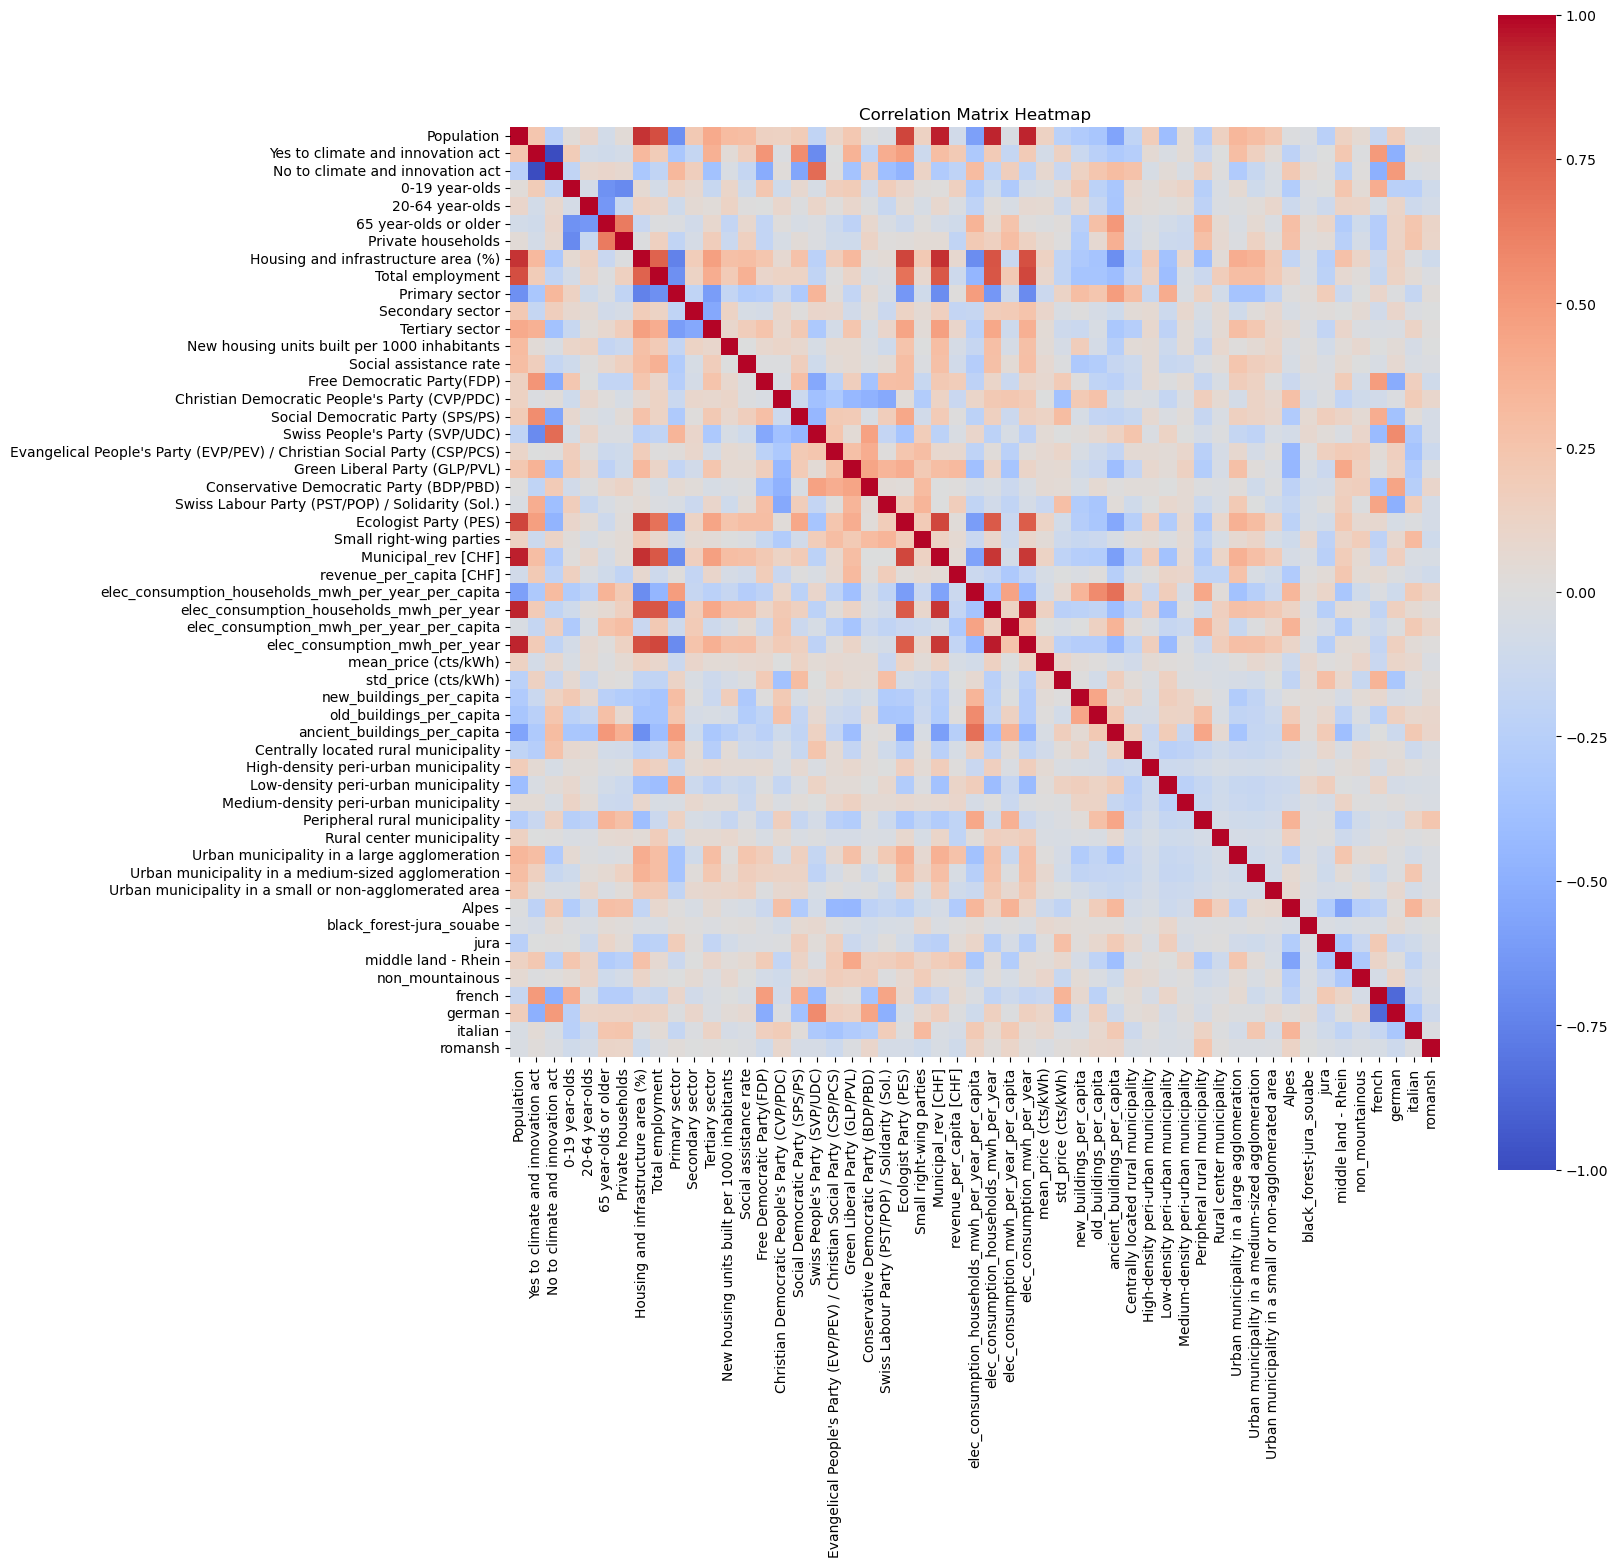

In [18]:
# Spearman's correlaiton coefficient 
correlation_matrix = scaled_processed_transformed_df.corr(method='spearman')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 15))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


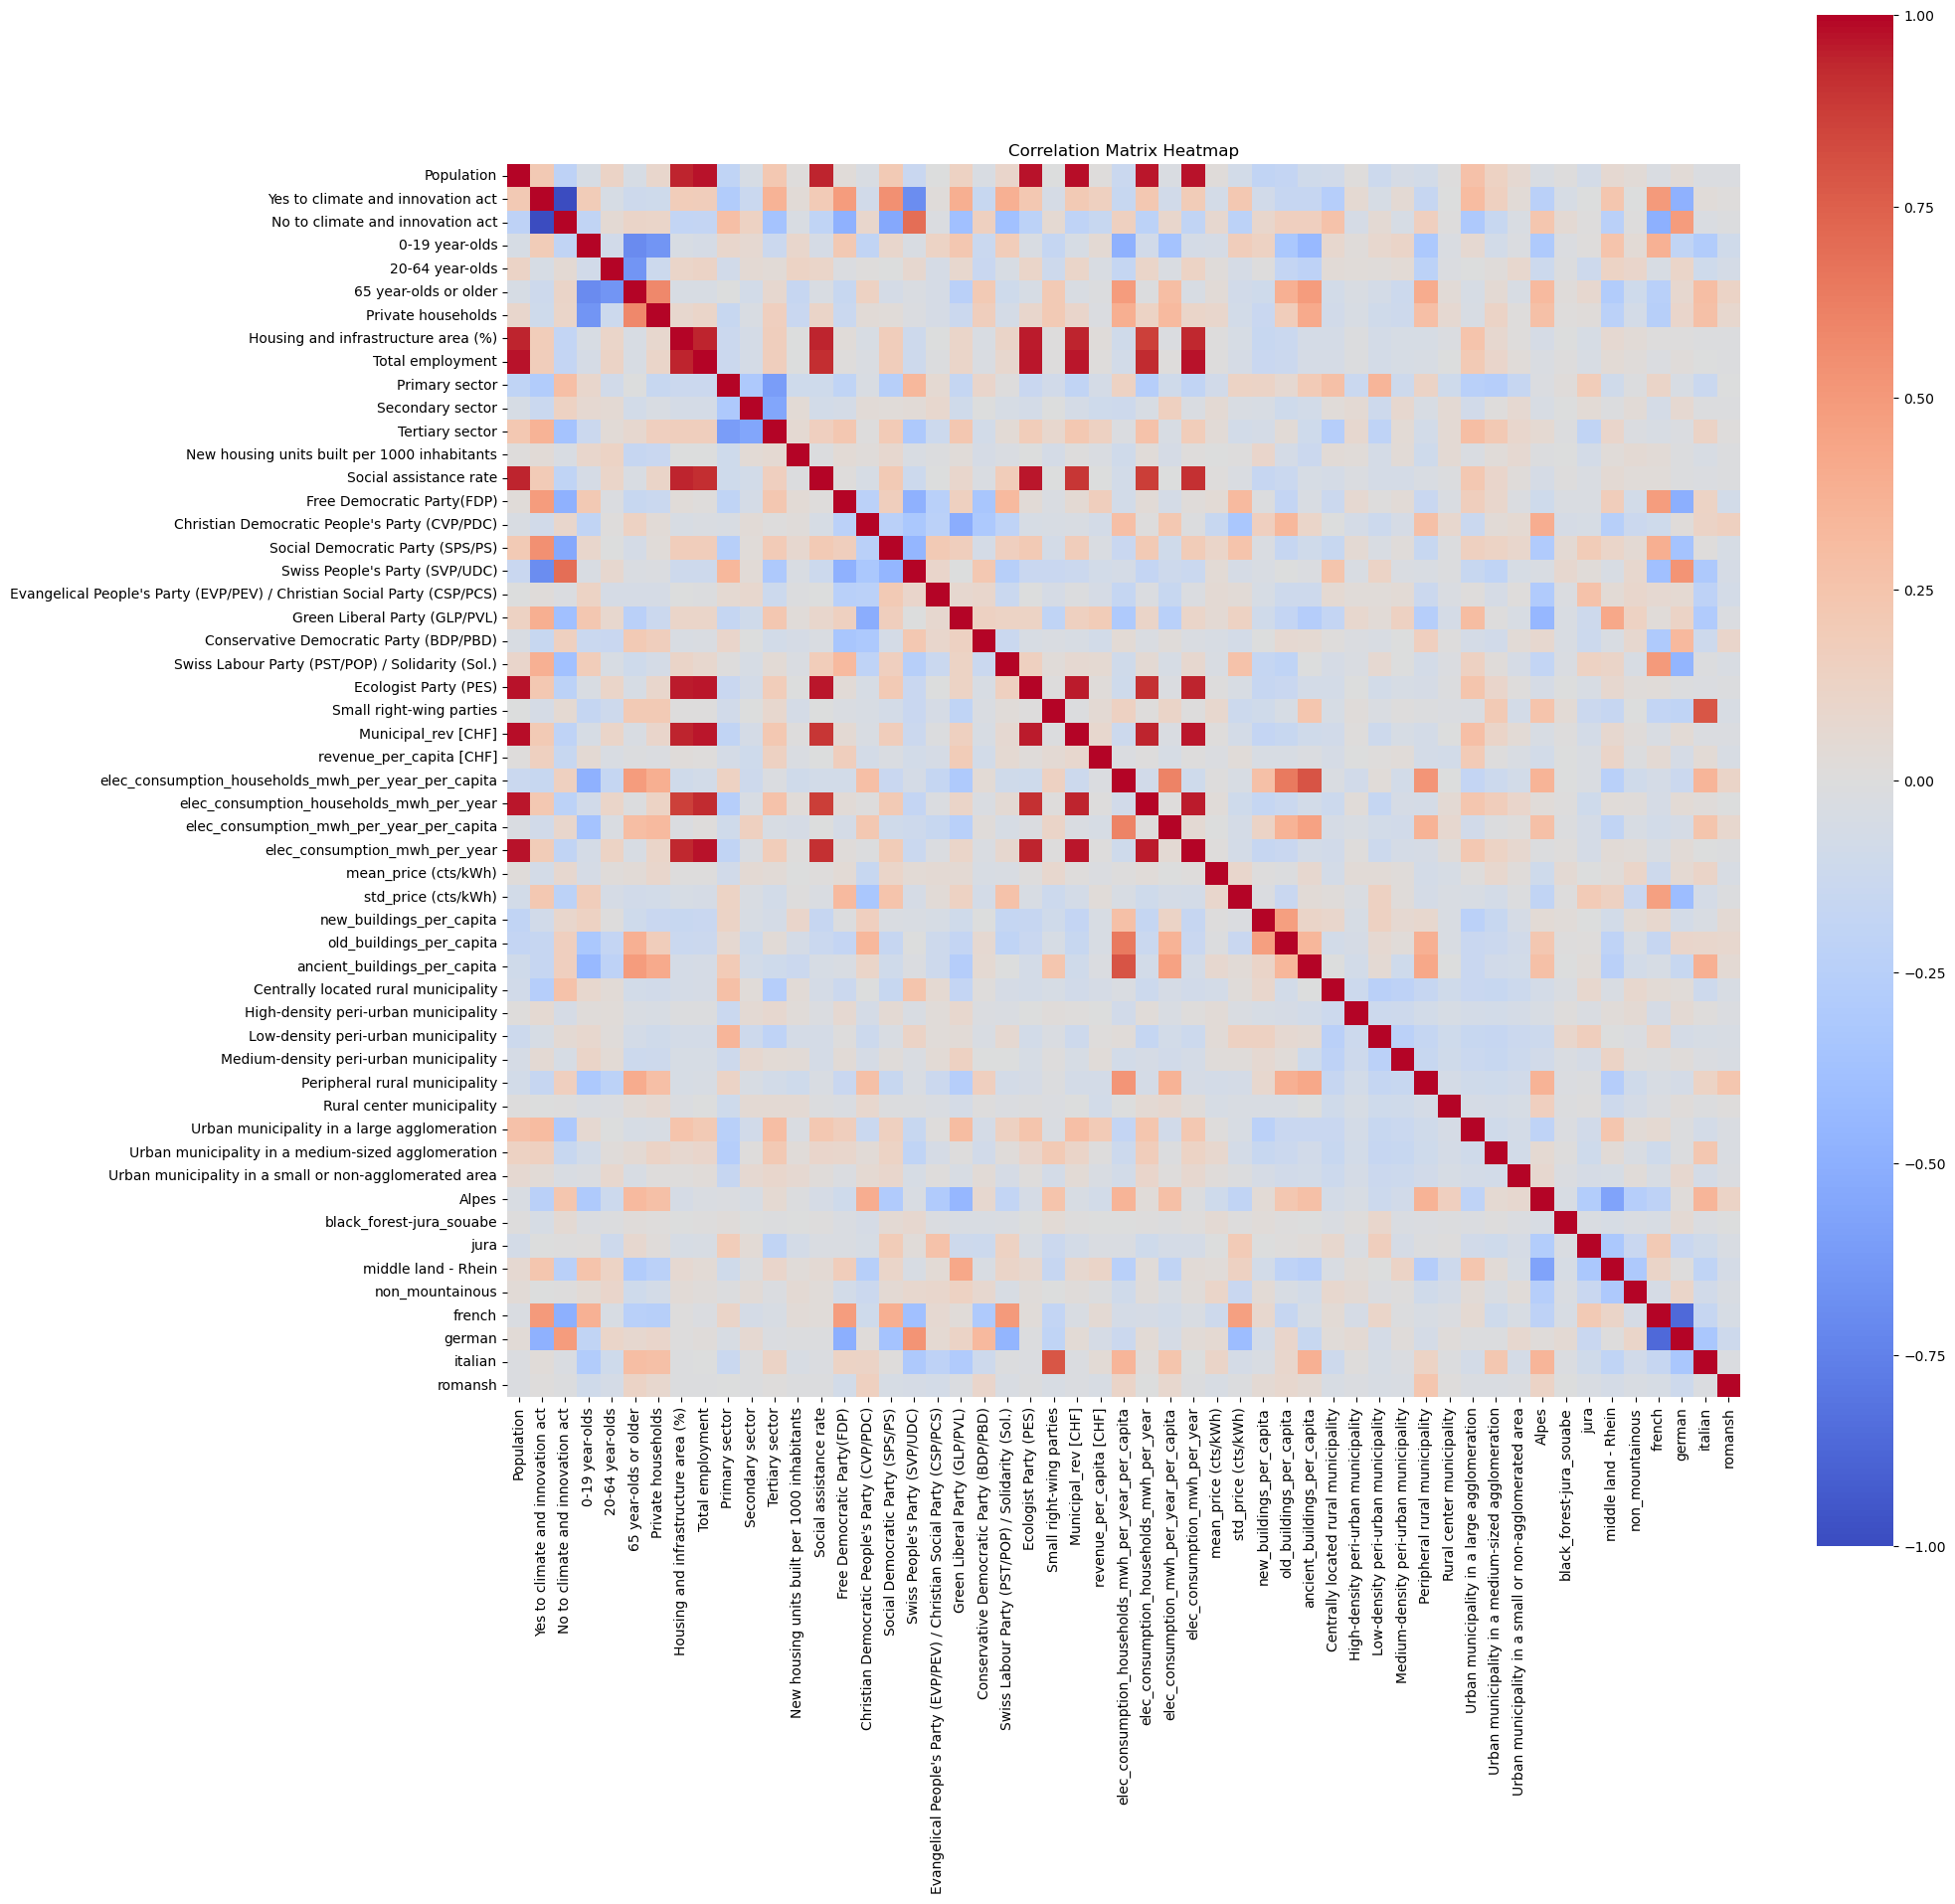

In [19]:
# Spearman's correlaiton coefficient 
correlation_matrix = scaled_processed_transformed_df.corr(method='pearson')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 20))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

The data seems to hold non linear relationships > which leads us to applying deep embedded clusteing coupled to DBSCAN rather than PCA Analysis with K-means clustering

## Model definition

### Defintion of a simple model

In [17]:
# copying dataframe
df = scaled_processed_transformed_df.copy()

# Step 4: Define the Autoencoder Model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim)  # Latent space representation
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Returns the encoded (latent) representation of the input"""
        return self.encoder(x)

# Step 5: Prepare data for PyTorch (convert to tensors)
X_tensor = torch.tensor(df.values, dtype=torch.float32)

# Step 6: Instantiate the Autoencoder
input_dim = df.shape[1]
print(f"\nInput dim : {input_dim}\n")
encoding_dim = 3 # Latent space dimension (you can change this)
autoencoder = Autoencoder(input_dim, encoding_dim)

# Step 7: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Step 8: Train the Autoencoder
epochs = 100
batch_size = 16
dataset = TensorDataset(X_tensor, X_tensor)  # Input and output are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Running Neural network...")
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data  # We don't need the output, as we are using the input itself
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 9: Get the Encoded (Latent) Features
X_encoded = autoencoder.encode(X_tensor).detach().numpy()

np.savetxt('../../data/cleaned_data/X_encoded_simple.csv', X_encoded, delimiter=',')

print("\nModel trained!")



Input dim : 53

Running Neural network...
Epoch [10/100], Loss: 0.2361
Epoch [20/100], Loss: 0.5257
Epoch [30/100], Loss: 0.3074
Epoch [40/100], Loss: 0.2616
Epoch [50/100], Loss: 0.3497
Epoch [60/100], Loss: 0.2314
Epoch [70/100], Loss: 0.2791
Epoch [80/100], Loss: 0.3983
Epoch [90/100], Loss: 0.4234
Epoch [100/100], Loss: 0.3840

Model trained!


### Defintion of a more complex model

In [18]:
# Assuming you have a DataFrame of covariates called df
df = scaled_processed_transformed_df.copy()

# Step 3: Define the Autoencoder Model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder with Batch Normalization and Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, encoding_dim)  # Latent space representation
        )
        
        # Decoder with Batch Normalization and Dropout
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Returns the encoded (latent) representation of the input"""
        return self.encoder(x)

# Step 4: Prepare data for PyTorch (convert to tensors)
X_tensor = torch.tensor(df.values, dtype=torch.float32)

# Step 5: Instantiate the Autoencoder
input_dim = df.shape[1]  # Number of features in the dataset
encoding_dim = 4  # Increased latent space dimension
autoencoder = Autoencoder(input_dim, encoding_dim)

# Step 6: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Step 7: Train the Autoencoder
epochs = 100 #originally 100
batch_size = 8 # originally 16
dataset = TensorDataset(X_tensor, X_tensor)  # Input and output are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Running Neural network...")
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data  # We don't need the output, as we are using the input itself
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 8: Get the Encoded (Latent) Features
X_encoded = autoencoder.encode(X_tensor).detach().numpy()

# Save the array to a CSV file
np.savetxt('../../data/cleaned_data/X_encoded.csv', X_encoded, delimiter=',')

print("\nModel trained !")


Running Neural network...
Epoch [10/100], Loss: 0.4938
Epoch [20/100], Loss: 0.3742
Epoch [30/100], Loss: 0.3183
Epoch [40/100], Loss: 0.2693
Epoch [50/100], Loss: 0.2345
Epoch [60/100], Loss: 0.4794
Epoch [70/100], Loss: 0.3988
Epoch [80/100], Loss: 0.6370
Epoch [90/100], Loss: 0.3233
Epoch [100/100], Loss: 0.4258

Model trained !


## Analyzing latent space

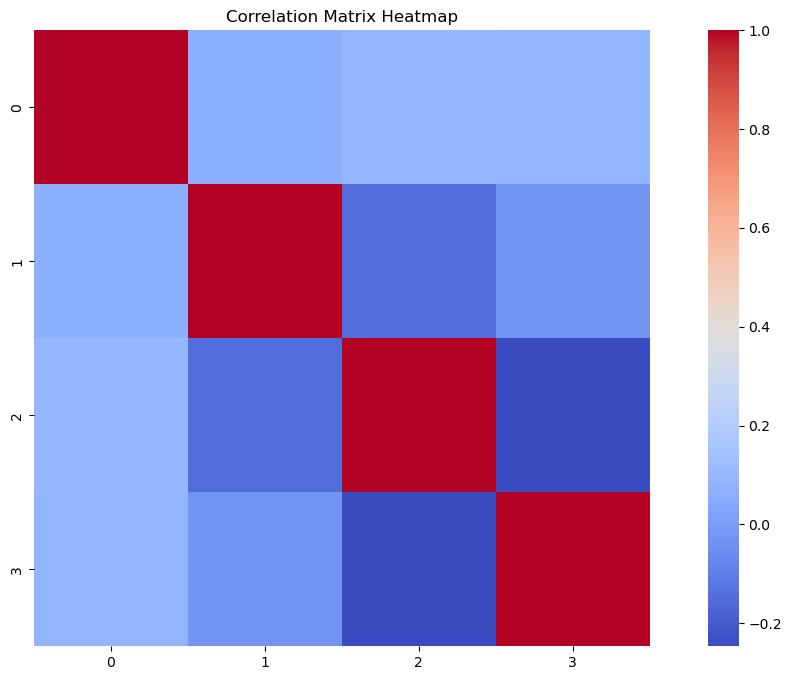

In [19]:
# Spearman's correlaiton coefficient 
correlation_matrix = np.corrcoef(X_encoded, rowvar=False)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

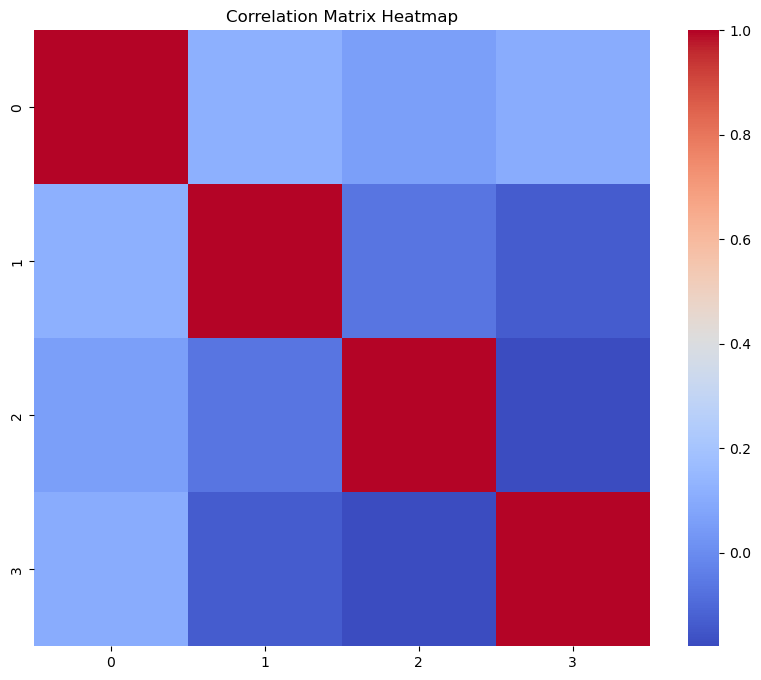

In [20]:
from scipy.stats import spearmanr

# Calculate the Spearman correlation matrix
corr, _ = spearmanr(X_encoded, axis=0)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

## DBSCAN clustering

ep: 0.01
ms: 2
[-1  0]
ms: 3
[-1  0]
ms: 4
[-1  0]
ms: 5
[-1  0]
ms: 6
[-1  0]
ms: 7
[-1  0]
ms: 8
[-1  0]
ms: 9
[-1  0]
ms: 10
[-1  0]
ms: 11
[-1  0]
ms: 12
[-1  0]
ms: 13
[-1]
ms: 14
[-1]
ep: 0.09777777777777778
ms: 2
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
ms: 3
[-1  0  1  2]
ms: 4
[-1  0  1]
ms: 5
[-1  0]
ms: 6
[-1  0]
ms: 7
[-1  0]
ms: 8
[-1  0]
ms: 9
[-1  0]
ms: 10
[-1  0]
ms: 11
[-1  0]
ms: 12
[-1  0]
ms: 13
[-1  0]
ms: 14
[-1  0]
ep: 0.18555555555555558
ms: 2
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120

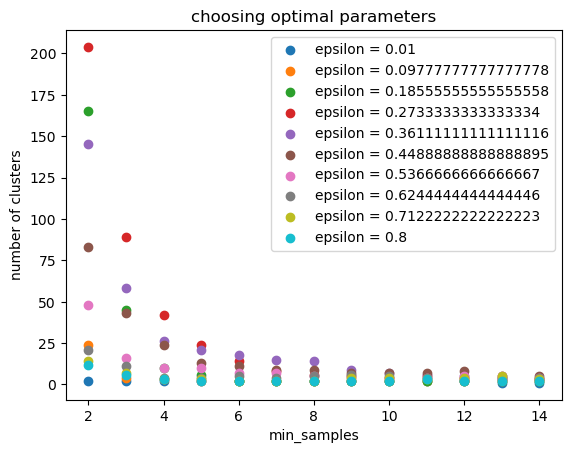

In [21]:
eps = np.linspace(0.01, 0.8, 10)
min_samples_array = np.arange(2, 15, 1)

for ep in eps:
    print("ep:", ep)
    clust_number_list = []
    for ms in min_samples_array:
        
        print("ms:", ms)
        # Step 9: Apply DBSCAN to the latent space
        dbscan_algo = DBSCAN(eps=ep, min_samples=ms)  # Adjust eps and min_samples as needed
        clusters = dbscan_algo.fit_predict(X_encoded)
        print(np.unique(clusters))
        clust_number_list.append(len(np.unique(clusters)))
    plt.scatter(min_samples_array, clust_number_list, label=f"epsilon = {ep}")
plt.xlabel("min_samples")
plt.ylabel("number of clusters")
plt.legend()
plt.title("choosing optimal parameters")
plt.show()

In [22]:

# Step 9: Apply DBSCAN to the latent space
dbscan = DBSCAN(eps=0.4, min_samples=14)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(X_encoded)

# Step 10: Optionally, you can visualize the clusters or perform further evaluation
print("Cluster labels:", clusters)

Cluster labels: [-1 -1 -1 ... -1 -1 -1]


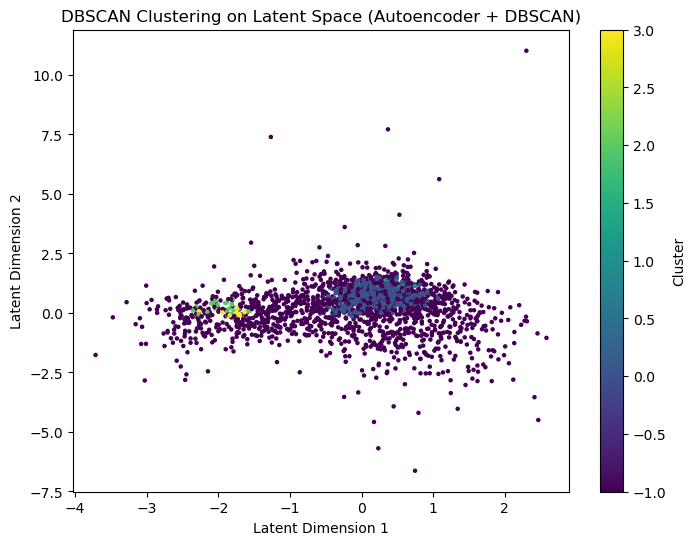

Silhouette Score: -0.25276660919189453
Davies-Bouldin Index: 2.4000290102425423
Cluster labels: [-1 -1 -1 ... -1 -1 -1]


In [23]:
# Step 11: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=clusters, cmap='viridis', s=5)
plt.title("DBSCAN Clustering on Latent Space (Autoencoder + DBSCAN)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 12: Evaluate the clustering (optional)
silhouette_avg = silhouette_score(X_encoded, clusters)
print(f"Silhouette Score: {silhouette_avg}")

db_score = davies_bouldin_score(X_encoded, clusters)
print(f"Davies-Bouldin Index: {db_score}")

# Cluster and True Labels comparison (if you have labels)
print("Cluster labels:", clusters)

## K-Means Clustering

In [20]:
#X_latent = np.genfromtxt("../../data/cleaned_data/X_encoded_simple_to_keep.csv", delimiter=",")
X_latent = np.genfromtxt("../../data/cleaned_data/X_encoded_simple_best.csv", delimiter=",")
#X_latent = np.genfromtxt("../../data/cleaned_data/X_encoded.csv", delimiter=",")


In [21]:
# Number of clusters to test
number_of_clusters = np.arange(2, 21)  # Clusters from 2 to 20

# Lists to store evaluation scores
silhouette_list = []
davies_bouldin_list = []
silhouette_max=0

for num_clusters in number_of_clusters: 
    # Step 9: Apply K-Means to the latent space
    kmeans = KMeans(n_clusters=num_clusters,  init='k-means++', n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X_latent)

    # Step 11: Evaluate clustering performance
    silhouette_avg = silhouette_score(X_latent, clusters)
    silhouette_list.append(silhouette_avg)

    davies_bouldin = davies_bouldin_score(X_latent, clusters)
    davies_bouldin_list.append(davies_bouldin)

    if silhouette_avg >= silhouette_max:
        silhouette_max = silhouette_avg
        kept_cluster_number = num_clusters
        best_clusters = clusters


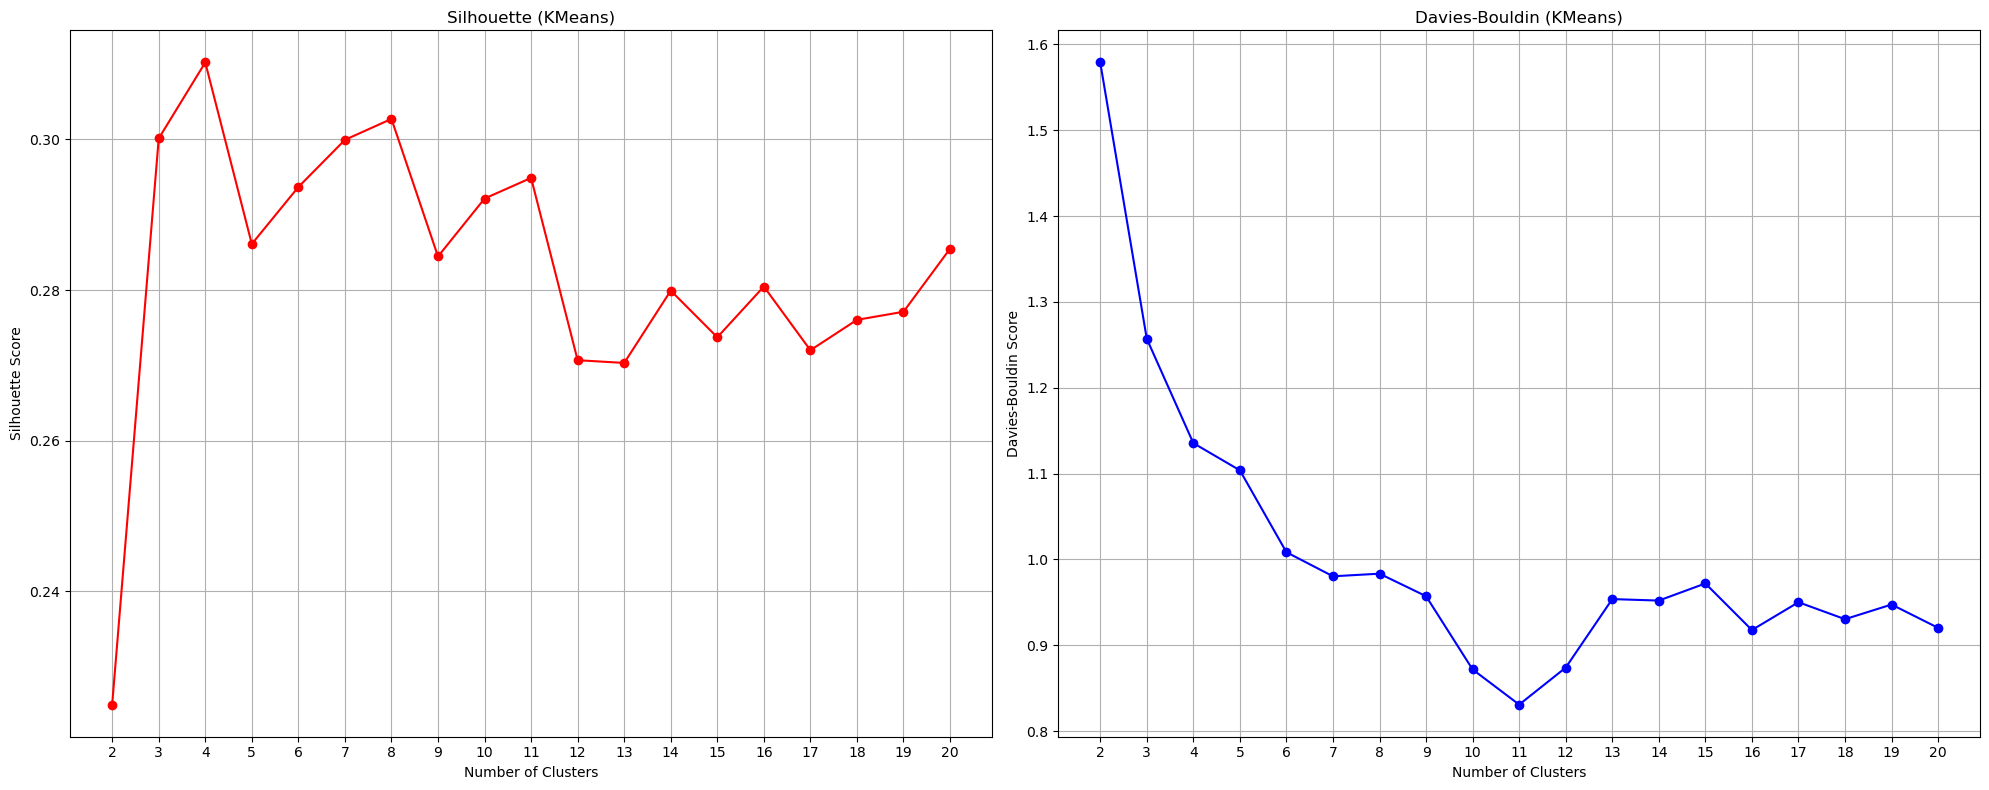

In [30]:
# Optional Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Silhouette scores plot
plt.grid()
axes[0].plot(number_of_clusters, silhouette_list, marker="o", color="red")
axes[0].set_title("Silhouette (KMeans)")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_xticks(number_of_clusters)
axes[0].grid(True)


# Davies-Bouldin scores plot
plt.grid()
axes[1].plot(number_of_clusters, davies_bouldin_list, marker="o", color="blue")
axes[1].set_title("Davies-Bouldin (KMeans)")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Davies-Bouldin Score")
axes[1].set_xticks(number_of_clusters)
axes[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [31]:
X_latent

array([[-12.35331154,  -9.72335052,   1.39376462],
       [-10.87697315,  -7.57047892,   6.01893282],
       [-10.44701862,  -9.29172993,   3.105865  ],
       ...,
       [ -3.21298528,  -1.83228111,  -3.40277576],
       [ -2.09416318,  -1.13809872,  -6.17561483],
       [ -2.49372029,  -0.18763684,  -6.4127121 ]])

Cluster labels: [7 0 0 ... 1 1 1]
Silhouette Score: 0.3027
Davies-Bouldin Score: 0.9833


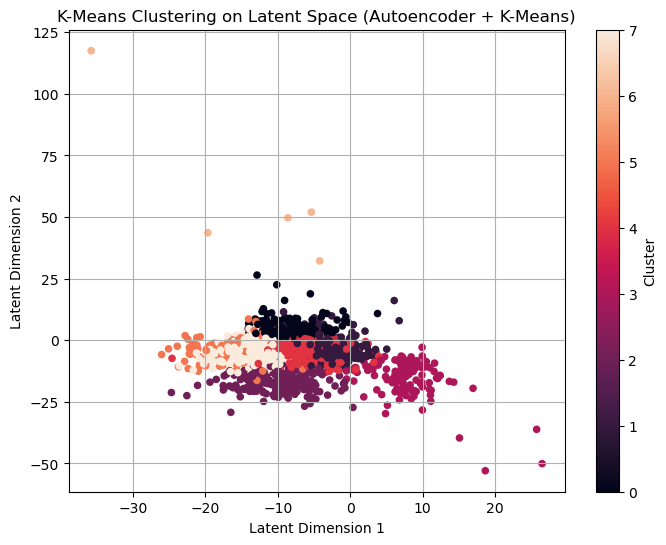

2131


In [63]:

# Step 9: Apply K-Means to the latent space
num_clusters = 8 # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters,  init='k-means++', n_init=10, random_state=42)
clusters_vect = kmeans.fit_predict(X_latent)

# Step 10: Optionally, you can visualize the clusters or perform further evaluation
print("Cluster labels:", clusters_vect)

# Step 11: Evaluate clustering performance
silhouette_avg = silhouette_score(X_latent, clusters_vect)
davies_bouldin = davies_bouldin_score(X_latent, clusters_vect)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")


# Optional Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_latent[:, 0], X_latent[:,2], c=clusters_vect, cmap='rocket', s=20)
plt.title("K-Means Clustering on Latent Space (Autoencoder + K-Means)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

print(len(clusters_vect))

## Visualizing types

In [73]:
Covariates_trans_df = scaled_processed_transformed_df.copy()
Covariates_trans_df["type"] = clusters_vect
Covariates_df["municipality_type"] = clusters_vect
Covariates_trans_df.columns =[
    'population',
    'yes_votes_for_climate_and_innovation_act',
    'no_votes_for_climate_and_innovation_act',
    'age_group_0_to_19',
    'age_group_20_to_64',
    'age_group_65_and_older',
    'number_of_private_households',
    'housing_and_infrastructure_area_percentage',
    'total_employment',
    'employment_in_primary_sector',
    'employment_in_secondary_sector',
    'employment_in_tertiary_sector',
    'new_housing_units_per_1000_inhabitants',
    'social_assistance_rate',
    'free_democratic_party',
    'christian_democratic_peoples_party',
    'social_democratic_party',
    'swiss_peoples_party',
    'evangelical_peoples_party_or_christian_social_party',
    'green_liberal_party',
    'conservative_democratic_party',
    'swiss_labour_party_or_solidarity',
    'ecologist_party',
    'small_right_wing_parties',
    'municipal_revenue_in_chf',
    'revenue_per_capita_in_chf',
    'electricity_consumption_by_households_in_mwh_per_year_per_capita',
    'electricity_consumption_by_households_in_mwh_per_year',
    'electricity_consumption_in_mwh_per_year_per_capita',
    'electricity_consumption_in_mwh_per_year',
    'average_electricity_price_in_cents_per_kwh',
    'standard_deviation_of_electricity_price_in_cents_per_kwh',
    'new_buildings_per_capita',
    'old_buildings_per_capita',
    'ancient_buildings_per_capita',
    'centrally_located_rural_municipality',
    'high_density_periurban_municipality',
    'low_density_periurban_municipality',
    'medium_density_periurban_municipality',
    'peripheral_rural_municipality',
    'rural_center_municipality',
    'urban_municipality_in_large_agglomeration',
    'urban_municipality_in_medium_sized_agglomeration',
    'urban_municipality_in_small_or_non_agglomerated_area',
    'region_alpes',
    'region_black_forest_or_jura_souabe',
    'region_jura',
    'region_middle_land_or_rhein',
    'region_non_mountainous',
    'language_french',
    'language_german',
    'language_italian',
    'language_romansh', 
    'municipality_type'
]
Covariates_df[Covariates_df["municipality_type"]==6]

,MunicipalityNumber,MunicipalityName,urban_typo,mountain_type,mountain_binary,Population,language,Canton,Yes [nbr],No [nbr],...,elec_consumption_households_mwh_per_year,elec_consumption_mwh_per_year_per_capita,elec_consumption_mwh_per_year,mean_price (cts/kWh),std_price (cts/kWh),building_new_age,building_medium_age,building_old_age,muicipality_type,municipality_type
151,261.0,Zürich,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,433989.0,german,Zürich,86847.0,25386.0,...,504869,5.9169,2567314,22.953061,2.454929,30153.0,73191.0,421602.0,6,6
191,351.0,Bern,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,136988.0,german,Bern / Berne,38050.0,8457.0,...,177425,6.7437,909163,30.450452,2.480758,4800.0,22236.0,179014.0,6,6
888,2701.0,Basel,Urban municipality in a large agglomeration (11),pas de classification,Communes hors des régions de montagne,176329.0,german,Basel-Stadt,32595.0,11151.0,...,230122,8.6747,1511130,31.170736,3.452708,4646.0,27415.0,235447.0,6,6
1692,5586.0,Lausanne,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,144160.0,french,Vaud,20694.0,4911.0,...,168754,4.5219,644694,29.280841,5.622529,10043.0,22074.0,93030.0,6,6
2056,6621.0,Genève,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,206635.0,french,Genève,26917.0,8082.0,...,194393,4.6315,948772,23.603403,2.495537,4274.0,21994.0,77502.0,6,6


In [34]:
typologies_df = Covariates_trans_df.groupby("municipality_type").mean()
typologies_df.mean()

population                                                          2.006066
yes_votes_for_climate_and_innovation_act                            0.339228
no_votes_for_climate_and_innovation_act                            -0.339228
age_group_0_to_19                                                  -0.169641
age_group_20_to_64                                                  0.167208
age_group_65_and_older                                              0.008700
number_of_private_households                                        0.240205
housing_and_infrastructure_area_percentage                          2.152748
total_employment                                                    2.089382
employment_in_primary_sector                                       -0.143521
employment_in_secondary_sector                                     -0.202881
employment_in_tertiary_sector                                       0.294775
new_housing_units_per_1000_inhabitants                             -0.092119

In [35]:
typologies_df_normalized = typologies_df.copy()
typologies_df_min_max = typologies_df.copy()

for col in typologies_df_normalized.columns:
    typologies_df_normalized[col] = (typologies_df_normalized[col]-typologies_df_normalized[col].mean())/typologies_df_normalized[col].std()
    typologies_df_min_max[col] = (typologies_df_min_max[col]-typologies_df_min_max[col].min())/(typologies_df_min_max[col].max()-typologies_df_min_max[col].min())


column_names = [
    'population',
    'yes_votes_for_climate_and_innovation_act',
    'no_votes_for_climate_and_innovation_act',
    'age_group_0_to_19',
    'age_group_20_to_64',
    'age_group_65_and_older',
    'number_of_private_households',
    'housing_and_infrastructure_area_percentage',
    'total_employment',
    'employment_in_primary_sector',
    'employment_in_secondary_sector',
    'employment_in_tertiary_sector',
    'new_housing_units_per_1000_inhabitants',
    'social_assistance_rate',
    'free_democratic_party',
    'christian_democratic_peoples_party',
    'social_democratic_party',
    'swiss_peoples_party',
    'evangelical_peoples_party_or_christian_social_party',
    'green_liberal_party',
    'conservative_democratic_party',
    'swiss_labour_party_or_solidarity',
    'ecologist_party',
    'small_right_wing_parties',
    'municipal_revenue_in_chf',
    'revenue_per_capita_in_chf',
    'electricity_consumption_by_households_in_mwh_per_year_per_capita',
    'electricity_consumption_by_households_in_mwh_per_year',
    'electricity_consumption_in_mwh_per_year_per_capita',
    'electricity_consumption_in_mwh_per_year',
    'average_electricity_price_in_cents_per_kwh',
    'standard_deviation_of_electricity_price_in_cents_per_kwh',
    'new_buildings_per_capita',
    'old_buildings_per_capita',
    'ancient_buildings_per_capita',
    'centrally_located_rural_municipality',
    'high_density_periurban_municipality',
    'low_density_periurban_municipality',
    'medium_density_periurban_municipality',
    'peripheral_rural_municipality',
    'rural_center_municipality',
    'urban_municipality_in_large_agglomeration',
    'urban_municipality_in_medium_sized_agglomeration',
    'urban_municipality_in_small_or_non_agglomerated_area',
    'region_alpes',
    'region_black_forest_or_jura_souabe',
    'region_jura',
    'region_middle_land_or_rhein',
    'region_non_mountainous',
    'language_french',
    'language_german',
    'language_italian',
    'language_romansh'
]
typologies_df_normalized.columns = column_names
typologies_df_min_max.columns= column_names

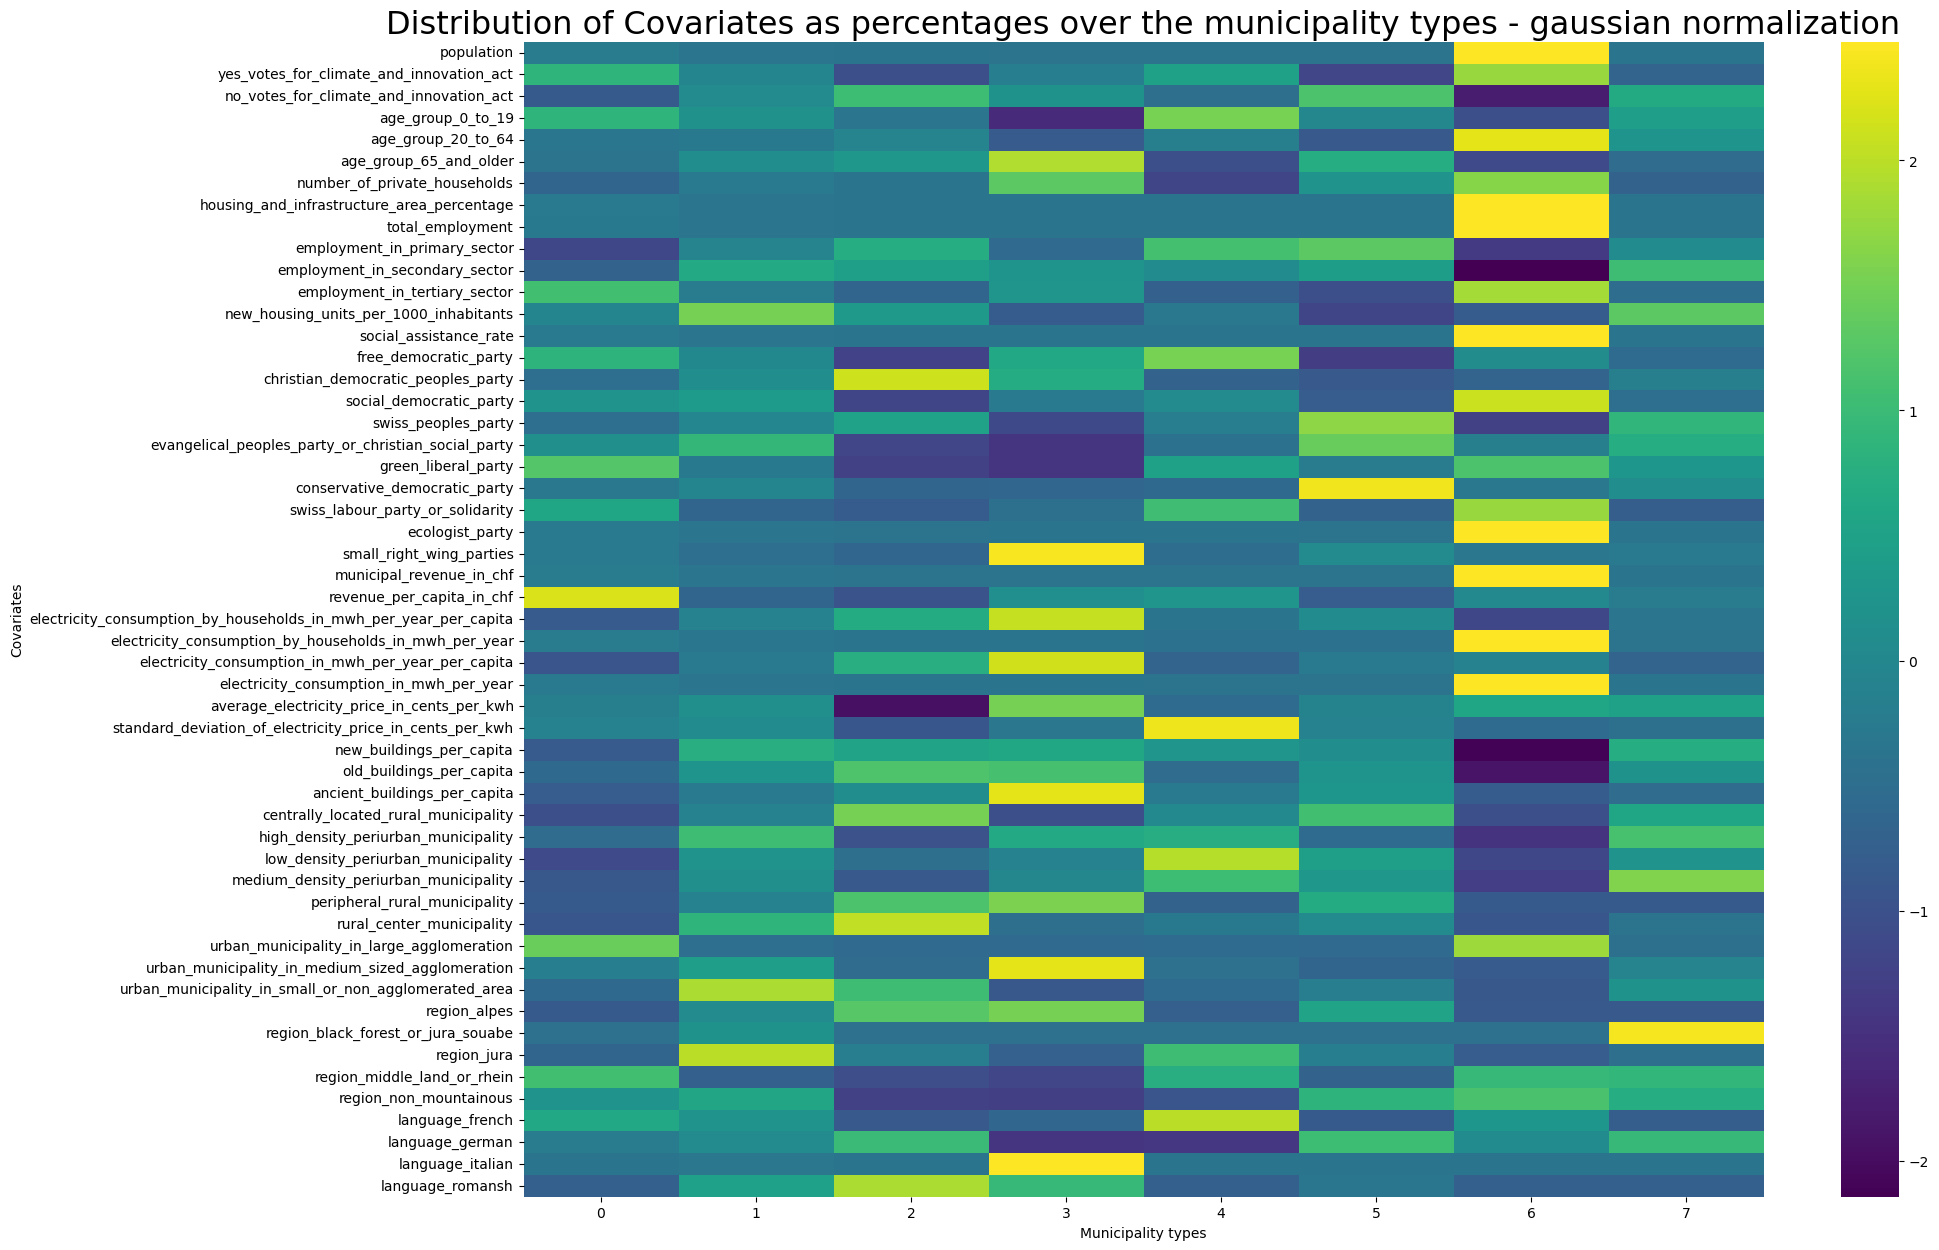

In [36]:
# Create a heatmap of the DataFrame
plt.figure(figsize=(20, 15))
sns.heatmap(typologies_df_normalized.T, annot=False, fmt='g', cmap='viridis', cbar=True)

# Add labels and title
plt.title("Distribution of Covariates as percentages over the municipality types - gaussian normalization", size=23)
plt.xlabel("Municipality types")
plt.ylabel("Covariates")
plt.show()

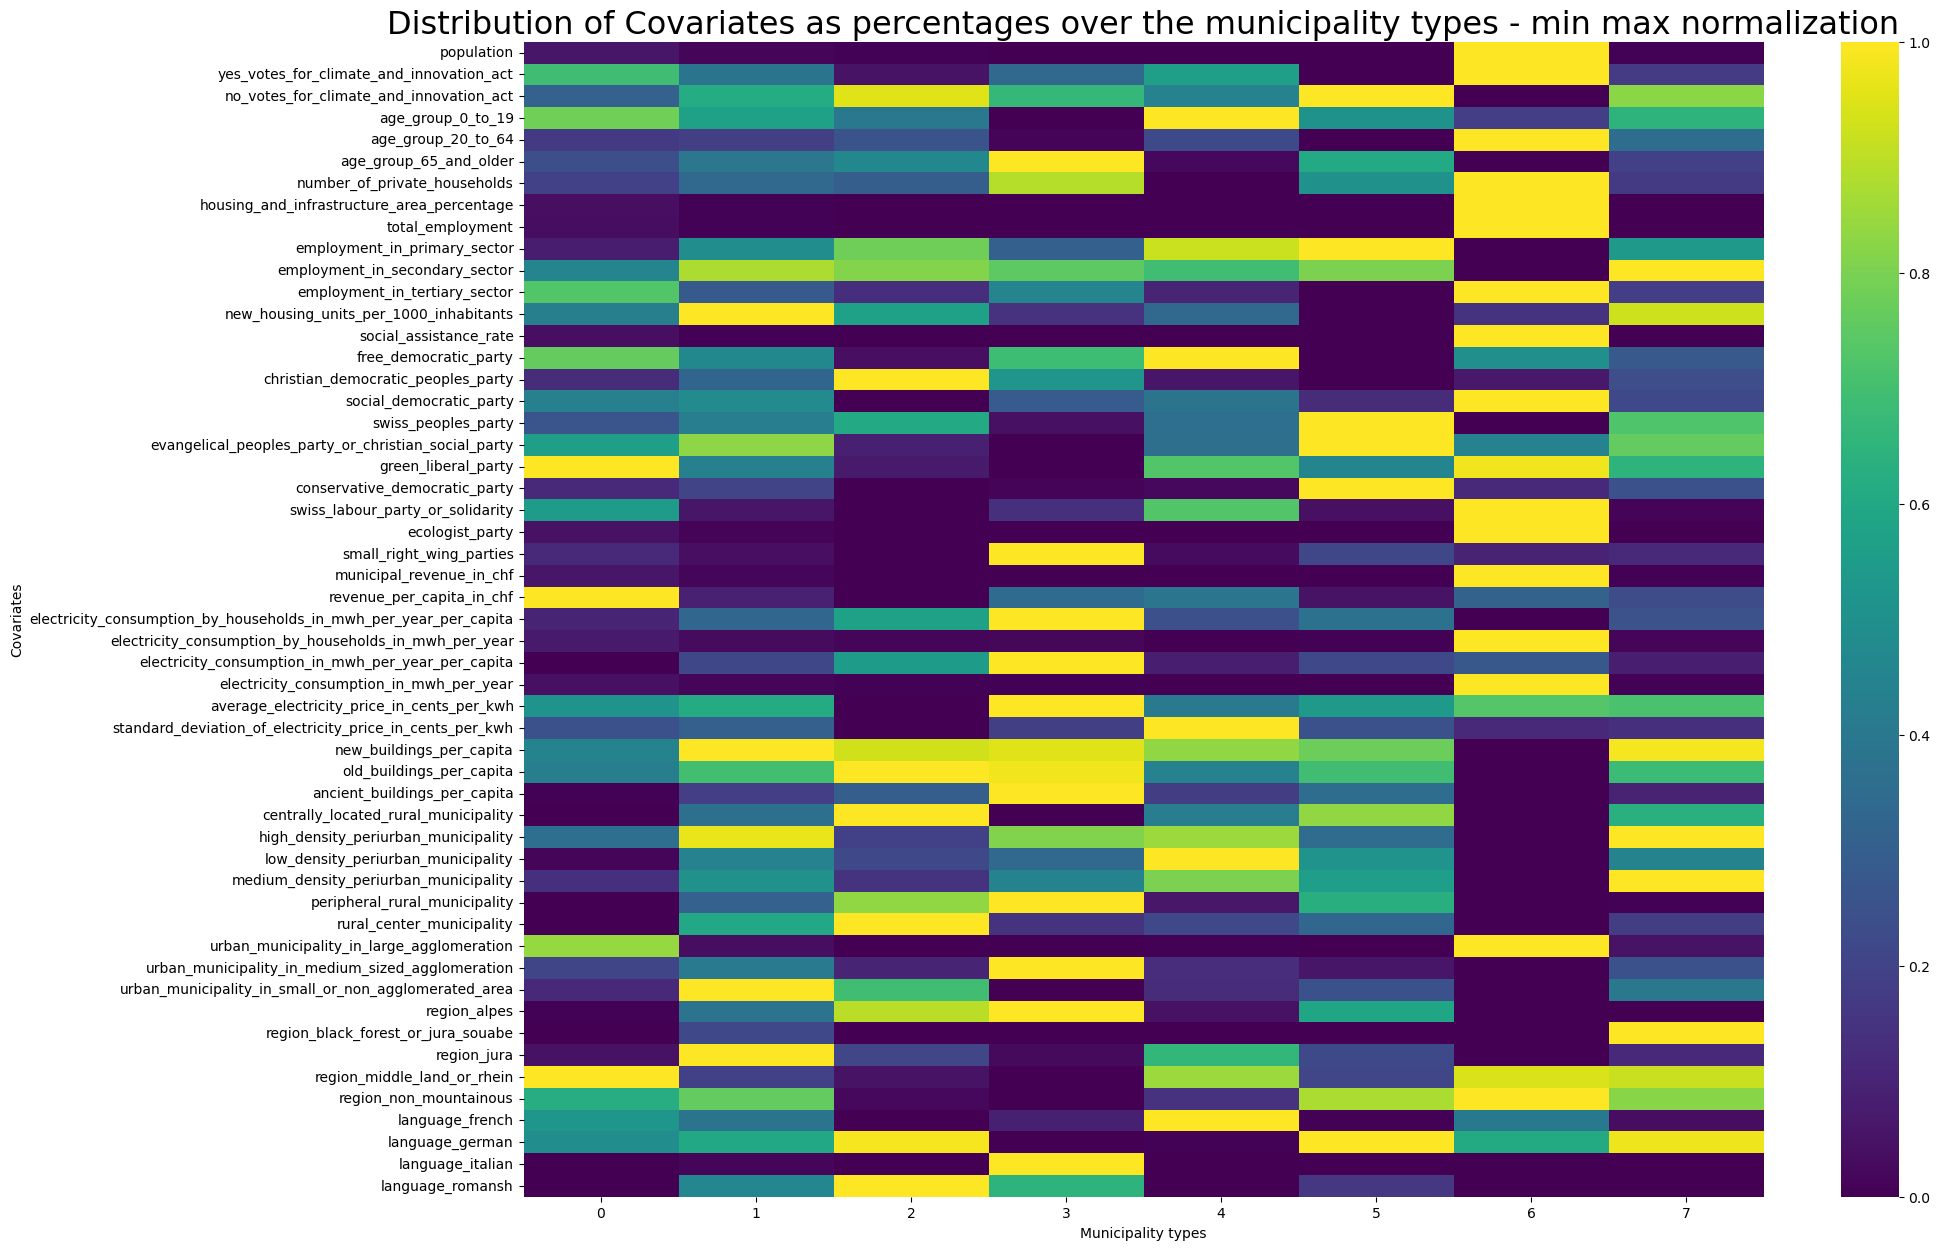

In [37]:
# Create a heatmap of the DataFrame
plt.figure(figsize=(20, 15))
sns.heatmap(typologies_df_min_max.T, annot=False, fmt='g', cmap='viridis', cbar=True)

# Add labels and title
plt.title("Distribution of Covariates as percentages over the municipality types - min max normalization", size=23)
plt.xlabel("Municipality types")
plt.ylabel("Covariates")
plt.show()

In [38]:
Covariates_trans_df

,population,yes_votes_for_climate_and_innovation_act,no_votes_for_climate_and_innovation_act,age_group_0_to_19,age_group_20_to_64,age_group_65_and_older,number_of_private_households,housing_and_infrastructure_area_percentage,total_employment,employment_in_primary_sector,...,region_alpes,region_black_forest_or_jura_souabe,region_jura,region_middle_land_or_rhein,region_non_mountainous,language_french,language_german,language_italian,language_romansh,municipality_type
0,-0.164167,0.489165,-0.489165,-0.207587,0.645798,-0.307013,0.314385,-0.120694,-0.150143,-0.427424,...,0,0,0,1,0,0,1,0,0,7
1,0.647875,0.743894,-0.743894,-0.094790,0.480800,-0.274049,0.237145,0.304738,0.318395,-0.925601,...,0,0,0,1,0,0,1,0,0,0
2,0.110975,1.002930,-1.002930,0.941221,-0.097560,-0.645999,-0.003046,-0.046973,-0.108772,-0.762045,...,0,0,0,1,0,0,1,0,0,0
3,-0.016428,0.569783,-0.569783,0.506756,-0.100980,-0.312920,-0.422508,-0.093483,-0.108265,-0.409980,...,0,0,0,1,0,0,1,0,0,7
4,-0.017250,0.597685,-0.597685,0.340900,0.474013,-0.600710,-0.245290,-0.060566,-0.075212,-0.847127,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,-0.216803,1.439041,-1.439041,-0.654864,-1.114707,1.300934,0.915934,-0.145444,-0.135460,0.976970,...,0,0,1,0,0,1,0,0,0,1
2127,-0.234522,0.823919,-0.823919,-0.804663,-1.470423,1.671047,1.453821,-0.145662,-0.125552,0.096654,...,0,0,1,0,0,1,0,0,0,1
2128,-0.228765,-0.056895,0.056895,0.263525,-1.929783,1.188930,0.615510,-0.144153,-0.153470,0.608407,...,0,0,1,0,0,1,0,0,0,1
2129,-0.286410,0.082770,-0.082770,-0.160832,-2.108187,1.640306,0.609963,-0.148536,-0.178423,1.634274,...,0,0,0,0,1,1,0,0,0,1


In [39]:
Covariates_trans_df.to_csv("../../data/cleaned_data/Covariates_types.csv")

## Importing PV data

In [76]:
Swiss_solar_potential = pd.read_csv("../../data/cleaned_data/Swiss_solar_potential.csv")
Swiss_solar_potential

,mun_name,canton_abr,pv_pot,pv_pot_reco,fpv_pot,fpv_pot_reco,roof_area,facade_area,total_power,total_energy,...,Scenario3_RoofsFacades_PotentialSolarElectricity_Month08_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month09_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month10_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month11_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month12_GWh,Scenario4_RoofsFacades_PotentialSolarElectricity_GWh,Scenario4_RoofsFacades_PotentialSolarHeat_GWh,Factsheet,Methodology,mun_id
0,Sévaz,FR,4.670673e+06,4.180890e+06,1.929158e+06,1.425327e+06,39036.054397,33832.332298,3693.98,3693980.0,...,1.72,1.35,0.87,0.50,0.35,13.55,0.86,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,2043
1,Onnens (VD),VD,1.305776e+07,1.177943e+07,3.235058e+06,2.103798e+06,112876.590943,63996.552432,8615.12,8615120.0,...,2.12,1.67,1.02,0.57,0.42,15.85,1.54,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,5565
2,Cressier (NE),NE,1.679586e+07,1.422929e+07,7.305761e+06,4.541674e+06,146427.208998,153540.786324,9229.40,9229400.0,...,3.73,2.97,1.86,1.04,0.79,26.41,4.48,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,6452
3,Clarmont,VD,1.777467e+06,1.489369e+06,9.465443e+05,6.455402e+05,13871.650234,16173.060807,986.84,986840.0,...,0.38,0.32,0.21,0.12,0.10,2.79,0.46,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,5629
4,Giornico,TI,1.495146e+07,5.614214e+06,5.010771e+06,2.016368e+06,150042.723782,137640.972544,3393.20,3393200.0,...,1.21,0.99,0.66,0.36,0.28,8.37,1.72,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,5073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,Eisten,VS,1.159662e+06,6.201025e+05,7.894920e+05,3.089211e+05,12376.176170,18211.712716,0.00,0.0,...,0.28,0.24,0.18,0.10,0.08,2.15,0.40,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,6282
2127,Zwischbergen,VS,9.111890e+05,1.736294e+05,6.840052e+05,1.835165e+05,11167.439085,18390.274529,0.00,0.0,...,0.20,0.17,0.11,0.07,0.06,1.73,0.12,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,6011
2128,Ferrera,GR,1.881119e+06,1.338627e+06,1.155161e+06,6.540965e+05,18165.699377,24885.535927,0.00,0.0,...,0.39,0.33,0.23,0.14,0.11,2.82,0.77,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,3713
2129,Rongellen,GR,6.321874e+05,2.848915e+05,2.847475e+05,1.276220e+05,6435.525421,7305.033094,0.00,0.0,...,0.08,0.07,0.04,0.02,0.02,0.51,0.13,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,3711


In [77]:
Swiss_solar_potential = Swiss_solar_potential.sort_values(by="mun_id", ascending=True)


In [79]:
Swiss_solar_potential["municipality_type"]=clusters_vect
Swiss_solar_potential[Swiss_solar_potential["municipality_type"]==6]

,mun_name,canton_abr,pv_pot,pv_pot_reco,fpv_pot,fpv_pot_reco,roof_area,facade_area,total_power,total_energy,...,Scenario3_RoofsFacades_PotentialSolarElectricity_Month09_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month10_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month11_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month12_GWh,Scenario4_RoofsFacades_PotentialSolarElectricity_GWh,Scenario4_RoofsFacades_PotentialSolarHeat_GWh,Factsheet,Methodology,mun_id,municipality_type
1761,Zürich,ZH,1.173020e+09,8.256447e+08,8.140466e+08,3.866836e+08,1.288725e+07,1.990452e+07,53443.86,53443860.0,...,151.85,93.85,48.25,36.15,1130.25,456.94,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,261,6
1782,Bern,BE,5.606095e+08,4.128140e+08,3.271737e+08,1.716060e+08,5.427322e+06,7.513526e+06,25141.86,25141860.0,...,71.19,48.06,27.76,20.55,604.66,144.15,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,351,6
1483,Basel,BS,5.848140e+08,4.261760e+08,3.332382e+08,1.551066e+08,5.866243e+06,8.150225e+06,33590.46,33590460.0,...,67.24,46.87,25.03,18.80,533.90,176.28,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,2701,6
1879,Lausanne,VD,3.734897e+08,3.137341e+08,2.650313e+08,1.489611e+08,3.465463e+06,5.836569e+06,17498.35,17498350.0,...,55.02,37.86,22.52,16.84,465.08,125.01,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,5586,6
2048,Genève,GE,4.012565e+08,3.320554e+08,2.521632e+08,1.155805e+08,3.848463e+06,6.174442e+06,8569.50,8569500.0,...,51.48,32.66,17.94,12.95,438.78,105.49,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,6621,6


In [80]:
Swiss_solar_potential.columns

Index(['mun_name', 'canton_abr', 'pv_pot', 'pv_pot_reco', 'fpv_pot',
       'fpv_pot_reco', 'roof_area', 'facade_area', 'total_power',
       'total_energy', 'initial_power', 'total_potential',
       'recommended_potential', 'achieved_rp', 'achieved_tp', 'Canton',
       'Country', 'Scenario1_RoofsOnly_PotentialSolarElectricity_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month01_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month02_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month03_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month04_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month05_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month06_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month07_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month08_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month09_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectrici

In [81]:
Swiss_solar_potential["achieved_rp"].median()

0.0745356492374057

In [82]:
pv_typologies_df = Swiss_solar_potential.groupby("municipality_type")["achieved_rp"].agg(["median", "mean", "std"])
pv_typologies_df

,median,mean,std
municipality_type,,,
0,0.060403,0.066058,0.028004
1,0.082195,0.088659,0.052650
2,0.073610,0.090016,0.070440
3,0.051886,0.058613,0.053050
4,0.066496,0.079709,0.065734
5,0.066523,0.072172,0.039259
6,0.043020,0.040371,0.013975
7,0.084873,0.096940,0.045585


In [83]:
Swiss_solar_potential[Swiss_solar_potential.municipality_type==6]["achieved_rp"]

1761    0.044084
1782    0.043020
1483    0.057787
1879    0.037818
2048    0.019144
Name: achieved_rp, dtype: float64

In [84]:
Swiss_solar_potential["municipality_type"].value_counts()

municipality_type
1    635
7    484
4    262
5    261
2    209
0    146
3    129
6      5
Name: count, dtype: int64

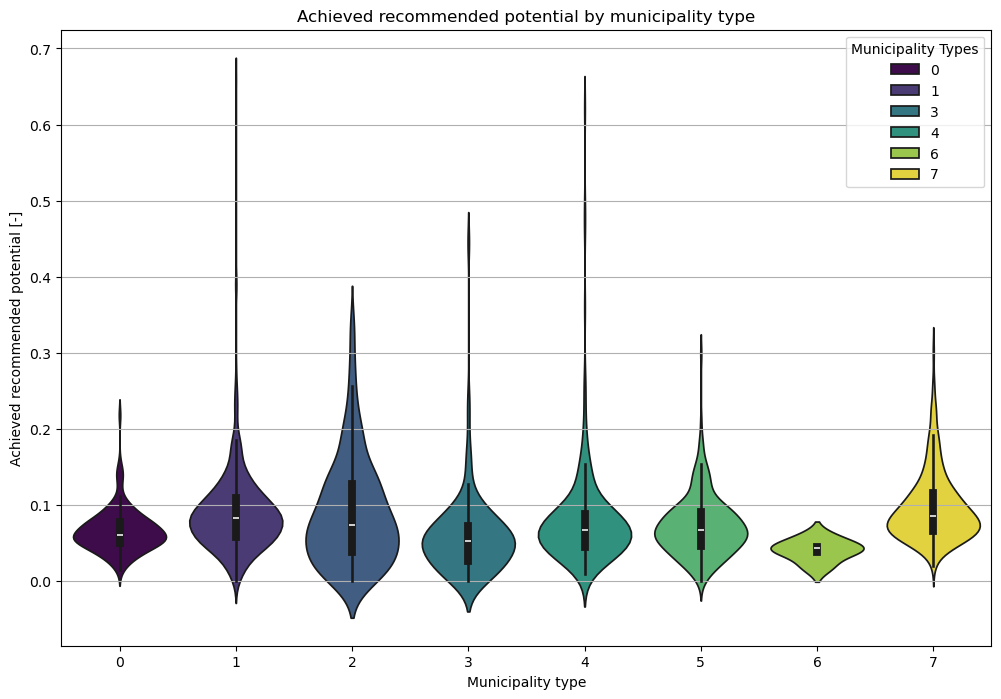

In [85]:
#Swiss_solar_potential.boxplot(column="achieved_rp", by="type", grid=False, figsize=(10, 6))

plt.figure(figsize=(12,8))
sns.violinplot(x="municipality_type", y="achieved_rp", hue="municipality_type", data=Swiss_solar_potential, palette="viridis")
plt.title("Achieved recommended potential by municipality type")
plt.xlabel("Municipality type")
plt.ylabel("Achieved recommended potential [-]")
plt.legend(title="Municipality Types")
plt.grid(axis="y")
plt.show()

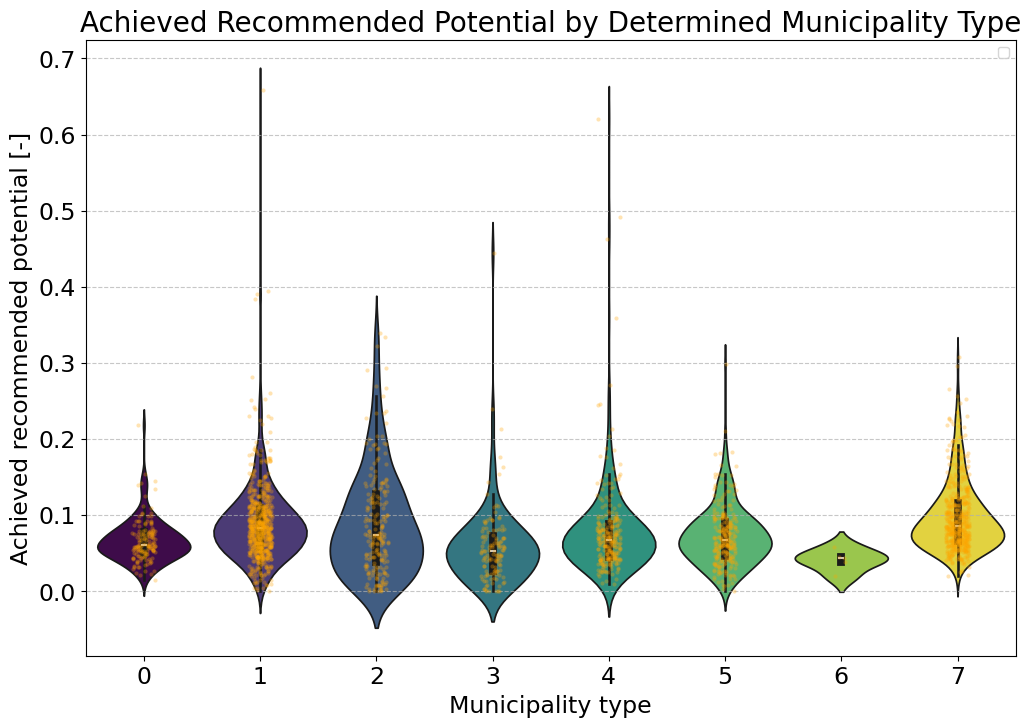

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Swiss_solar_potential DataFrame is already defined

plt.figure(figsize=(12, 8))

# Create the violin plot
sns.violinplot(x="municipality_type", y="achieved_rp", hue="municipality_type", data=Swiss_solar_potential, palette="viridis")

# Overlay the swarmplot for individual data points
#sns.swarmplot(x="type", y="achieved_rp", data=Swiss_solar_potential, color="black", size=3, alpha=0.7)
sns.stripplot(x="municipality_type", y="achieved_rp", data=Swiss_solar_potential, color="orange", size=3, alpha=0.3, jitter=True)


# Title and labels
plt.title("Achieved Recommended Potential by Determined Municipality Type", fontsize=20)
plt.xlabel("Municipality type", fontsize=17)
plt.ylabel("Achieved recommended potential [-]", fontsize=17)

# Add grid
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend([])
plt.xticks(size=17)
plt.yticks(size=17)

# Display the plot
plt.show()


In [119]:

# Get the top 10 largest values for each category
top_10_per_category = Swiss_solar_potential.groupby("municipality_type")[["municipality_type", "achieved_rp", "mun_id"]].apply(lambda x: x.nlargest(10, 'achieved_rp')).reset_index(drop=True)

print("\nTop 10 largest values for each category:")
print(top_10_per_category)



Top 10 largest values for each category:
    municipality_type  achieved_rp  mun_id
0                   0     0.218004    6461
1                   0     0.153856    4258
2                   0     0.144070    2702
3                   0     0.142153    5632
4                   0     0.138802    2764
..                ...          ...     ...
70                  7     0.247588    2962
71                  7     0.234968    4223
72                  7     0.230554    4077
73                  7     0.227691     408
74                  7     0.225908    4221

[75 rows x 3 columns]


In [120]:
average_std_top_10 = top_10_per_category.groupby("municipality_type")["achieved_rp"].agg(["mean", "std"]).reset_index()
average_std_top_10

,municipality_type,mean,std
0,0,0.137856,0.032794
1,1,0.335344,0.130920
2,2,0.284256,0.038232
3,3,0.188484,0.098965
4,4,0.329931,0.147818
5,5,0.184296,0.043907
6,6,0.040371,0.013975
7,7,0.254443,0.028206


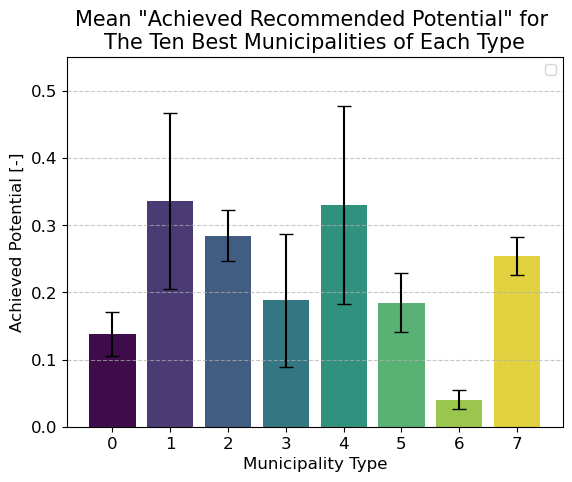

In [115]:
# Create the bar plot without the error bars
sns.barplot(
    x="municipality_type",
    y="mean",
    data=average_std_top_10,
    hue='municipality_type',
    palette="viridis"

)

# Add error bars using plt.errorbar
plt.errorbar(
    x=range(len(average_std_top_10)),
    y=average_std_top_10["mean"],
    yerr=average_std_top_10["std"],
    fmt='none',  # No markers, just error bars
    color='black',
    capsize=5
)

# Customizing the plot
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.title("Mean \"Achieved Recommended Potential\" for \nThe Ten Best Municipalities of Each Type", size=15)
plt.ylabel("Achieved Potential [-]", size=12)
plt.xlabel("Municipality Type", size=12)
plt.xticks(ticks=range(len(average_std_top_10)), labels=average_std_top_10["municipality_type"], rotation=0, size=12)
plt.yticks(size=12)
plt.ylim([0,0.55])
plt.legend([])
plt.show()


In [127]:
Reccommende_potential = Swiss_solar_potential[Swiss_solar_potential.mun_id.isin(top_10_per_category.mun_id)][["recommended_potential", "municipality_type"]]


In [128]:
average_std_top_10_reco = Reccommende_potential.groupby("municipality_type")["recommended_potential"].agg(["mean", "std"]).reset_index()
average_std_top_10_reco

,municipality_type,mean,std
0,0,3.864727e+07,2.436064e+07
1,1,1.205794e+07,1.064511e+07
2,2,2.235080e+07,1.769041e+07
3,3,2.456622e+07,1.927868e+07
4,4,1.456322e+07,2.040984e+07
5,5,1.047934e+07,9.664794e+06
6,6,6.576724e+08,3.166133e+08
7,7,1.567812e+07,1.318070e+07


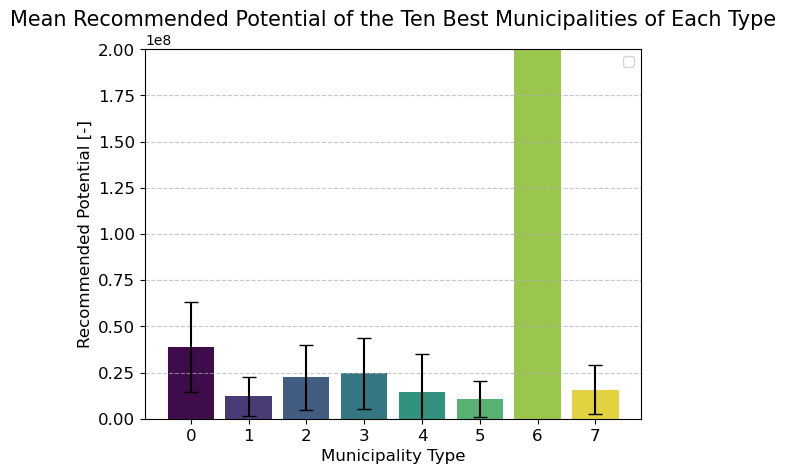

In [144]:
# Create the bar plot without the error bars
sns.barplot(
    x="municipality_type",
    y="mean",
    data=average_std_top_10_reco,
    hue='municipality_type',
    palette="viridis"

)

# Add error bars using plt.errorbar
plt.errorbar(
    x=range(len(average_std_top_10_reco)),
    y=average_std_top_10_reco["mean"],
    yerr=average_std_top_10_reco["std"],
    fmt='none',  # No markers, just error bars
    color='black',
    capsize=5
)

# Customizing the plot
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.title("Mean Recommended Potential of the Ten Best Municipalities of Each Type", size=15)
plt.ylabel("Recommended Potential [-]", size=12)
plt.xlabel("Municipality Type", size=12)
plt.xticks(ticks=range(len(average_std_top_10_reco)), labels=average_std_top_10_reco["municipality_type"], rotation=0, size=12)
plt.yticks(size=12)
#plt.ylim([0,0.55])
plt.legend([])
plt.ylim([0,2*10**8])
plt.show()


In [134]:

# Get the top 10 smallest values for each category
low_10_per_category = Swiss_solar_potential.groupby("municipality_type")[["municipality_type", "achieved_rp", "mun_id"]].apply(lambda x: x.nsmallest(10, 'achieved_rp')).reset_index(drop=True)

print("\nTop 10 smallest values for each category:")
print(low_10_per_category)



Top 10 smallest values for each category:
    municipality_type  achieved_rp  mun_id
0                   0     0.014379     245
1                   0     0.020367    6629
2                   0     0.021623    5708
3                   0     0.022926    6636
4                   0     0.025673    5590
..                ...          ...     ...
70                  7     0.034810    2885
71                  7     0.036881    2848
72                  7     0.036937      95
73                  7     0.037922      22
74                  7     0.038295      13

[75 rows x 3 columns]


In [135]:
average_std_low_10 = low_10_per_category.groupby("municipality_type")["achieved_rp"].agg(["mean", "std"]).reset_index()
average_std_low_10

,municipality_type,mean,std
0,0,0.025518,0.005803
1,1,0.005849,0.003977
2,2,0.001349,0.001621
3,3,0.001850,0.002538
4,4,0.018936,0.006056
5,5,0.009376,0.005439
6,6,0.040371,0.013975
7,7,0.030896,0.007219


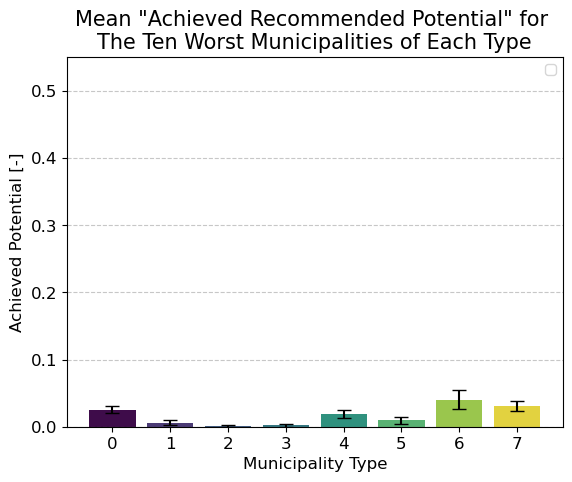

In [136]:
# Create the bar plot without the error bars
sns.barplot(
    x="municipality_type",
    y="mean",
    data=average_std_low_10,
    hue='municipality_type',
    palette="viridis"

)

# Add error bars using plt.errorbar
plt.errorbar(
    x=range(len(average_std_top_10)),
    y=average_std_low_10["mean"],
    yerr=average_std_low_10["std"],
    fmt='none',  # No markers, just error bars
    color='black',
    capsize=5
)

# Customizing the plot
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.title("Mean \"Achieved Recommended Potential\" for \nThe Ten Worst Municipalities of Each Type", size=15)
plt.ylabel("Achieved Potential [-]", size=12)
plt.xlabel("Municipality Type", size=12)
plt.yticks(size=12)
plt.xticks(ticks=range(len(average_std_low_10)), labels=average_std_low_10["municipality_type"], rotation=0, size=12)
plt.ylim([0,0.55])
plt.legend([])
plt.show()

In [139]:
Recommended_potential_low = Swiss_solar_potential[Swiss_solar_potential.mun_id.isin(low_10_per_category.mun_id)][["recommended_potential", "municipality_type"]]


In [140]:
average_std_low_10_reco = Recommended_potential_low.groupby("municipality_type")["recommended_potential"].agg(["mean", "std"]).reset_index()
average_std_low_10_reco

,municipality_type,mean,std
0,0,2.840255e+07,2.375123e+07
1,1,2.262114e+07,1.945286e+07
2,2,6.868598e+06,7.157236e+06
3,3,8.584315e+06,1.139161e+07
4,4,8.696186e+06,1.191450e+07
5,5,7.148252e+06,1.017513e+07
6,6,6.576724e+08,3.166133e+08
7,7,1.385790e+07,9.392576e+06


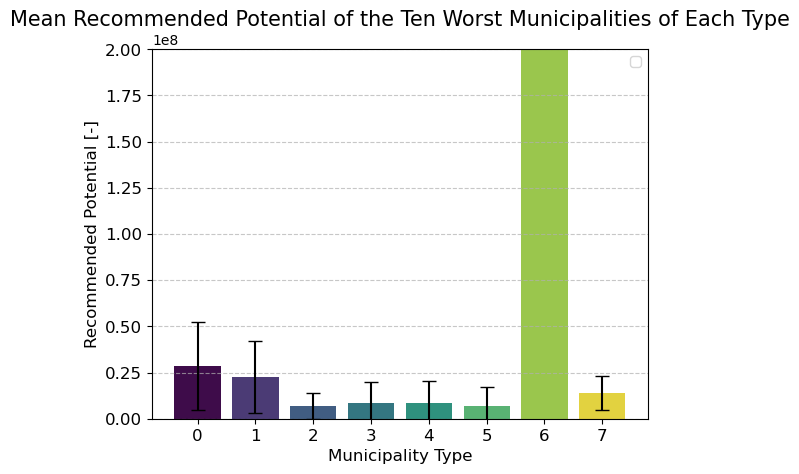

In [143]:
# Create the bar plot without the error bars
sns.barplot(
    x="municipality_type",
    y="mean",
    data=average_std_low_10_reco,
    hue='municipality_type',
    palette="viridis"

)

# Add error bars using plt.errorbar
plt.errorbar(
    x=range(len(average_std_low_10_reco)),
    y=average_std_low_10_reco["mean"],
    yerr=average_std_low_10_reco["std"],
    fmt='none',  # No markers, just error bars
    color='black',
    capsize=5
)

# Customizing the plot
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.title("Mean Recommended Potential of the Ten Worst Municipalities of Each Type", size=15)
plt.ylabel("Recommended Potential [-]", size=12)
plt.xlabel("Municipality Type", size=12)
plt.xticks(ticks=range(len(average_std_low_10_reco)), labels=average_std_low_10_reco["municipality_type"], rotation=0, size=12)
plt.yticks(size=12)
#plt.ylim([0,0.55])
plt.legend([])
plt.ylim([0,2*10**8])
plt.show()


## updating dataframe 

In [101]:
df_to_add = Covariates_df[["MunicipalityNumber","urban_typo"]]

In [102]:
Swiss_solar_potential_final = pd.merge(Swiss_solar_potential, df_to_add, left_on="mun_id", right_on="MunicipalityNumber")

In [103]:
Swiss_solar_potential_final.drop(columns=["MunicipalityNumber"], inplace=True)

In [104]:
Swiss_solar_potential_final.to_csv("../../data/cleaned_data/Municipal_solar_types.csv")

In [105]:
Swiss_solar_potential_final[Swiss_solar_potential_final.municipality_type==6]

,mun_name,canton_abr,pv_pot,pv_pot_reco,fpv_pot,fpv_pot_reco,roof_area,facade_area,total_power,total_energy,...,Scenario3_RoofsFacades_PotentialSolarElectricity_Month10_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month11_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month12_GWh,Scenario4_RoofsFacades_PotentialSolarElectricity_GWh,Scenario4_RoofsFacades_PotentialSolarHeat_GWh,Factsheet,Methodology,mun_id,municipality_type,urban_typo
151,Zürich,ZH,1.173020e+09,8.256447e+08,8.140466e+08,3.866836e+08,1.288725e+07,1.990452e+07,53443.86,53443860.0,...,93.85,48.25,36.15,1130.25,456.94,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,261,6,Urban municipality in a large agglomeration (11)
191,Bern,BE,5.606095e+08,4.128140e+08,3.271737e+08,1.716060e+08,5.427322e+06,7.513526e+06,25141.86,25141860.0,...,48.06,27.76,20.55,604.66,144.15,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,351,6,Urban municipality in a large agglomeration (11)
888,Basel,BS,5.848140e+08,4.261760e+08,3.332382e+08,1.551066e+08,5.866243e+06,8.150225e+06,33590.46,33590460.0,...,46.87,25.03,18.80,533.90,176.28,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,2701,6,Urban municipality in a large agglomeration (11)
1692,Lausanne,VD,3.734897e+08,3.137341e+08,2.650313e+08,1.489611e+08,3.465463e+06,5.836569e+06,17498.35,17498350.0,...,37.86,22.52,16.84,465.08,125.01,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,5586,6,Urban municipality in a large agglomeration (11)
2056,Genève,GE,4.012565e+08,3.320554e+08,2.521632e+08,1.155805e+08,3.848463e+06,6.174442e+06,8569.50,8569500.0,...,32.66,17.94,12.95,438.78,105.49,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,6621,6,Urban municipality in a large agglomeration (11)
